# 03 — Knowledge Graph + Exports

This notebook builds a small, typed knowledge graph from:

- `items.parquet` (metadata + text)
- `fused_embeddings.parquet` (for similarity edges)
- `clusters.parquet` (item→cluster edges)

Outputs:
- `exports/kg/entities.parquet`
- `exports/kg/edges.parquet`
- `exports/kg/provenance.parquet`
- `exports/kg/graph.ttl` (RDF Turtle, if rdflib installed)
- `exports/kg/neo4j/*` (CSV + Cypher snippet)
- `exports/dag.mmd` (Mermaid DAG of executed cells, best-effort)

Everything is Drive-first and restart-safe.


## PR changes in this notebook (demo credibility)

### ✅ Similarity-edge provenance
`SIMILAR_TO` edges now include:
- `rank` (neighbor rank)
- `distance` / `similarity`
- `embedding_version`
- `pipeline_version`

**Pros:** makes the KG explainable and auditable in a demo.  
**Cons:** slightly larger parquet files; “similarity” still depends on the embedding quality.

### ✅ KG QA outputs (`exports/kg_qa/`)
This notebook now exports:
- within-label vs cross-label similarity rates (by label)
- top cross-label confusion pairs
- similarity weight histograms + stats JSON (spike/truncation checks)
- low-degree / unconnected nodes
- outlier candidates (nearest neighbors mostly cross-label)

### ✅ Semantic layer readiness (`exports/semantic/`)
We export:
- `exports/kg/consolidated_graph.ttl` (RDF Turtle)
- `exports/semantic/ontology.ttl` (minimal scaffold: PATCH/SLIDE/LABEL/FEATURE)
- `exports/semantic/mapping_spec.md` (column→node/edge mapping notes)

These are intended for migration later; they do not replace the parquet-first workflow today.


## Math notes (Knowledge graph, provenance, and exports)

These notes formalize what we export as `entities.parquet`, `edges.parquet`, and `provenance.parquet`.

### 1) Graph as a typed, attributed multigraph

We build a directed graph:

$$
G = (V, E)
$$

where:

- each node $v \in V$ has:
  - an id: `entity_id`
  - a type: `entity_type` (ITEM, LABEL, CLUSTER, DATASET, ...)
  - attributes (name, description, etc.)

- each edge $e \in E$ has:
  - a source node $s(e)$
  - a destination node $t(e)$
  - a relation type $r(e)$ in a controlled vocabulary
  - a weight $w(e)$ (optional)
  - provenance pointer `provenance_id`

This is best viewed as a **property graph** with typed relationships.

### 2) Why separate provenance as a table?

In many KG use-cases, you need to answer:

- *Where did this edge come from?*
- *Was it computed or extracted?*
- *What evidence supports it?*
- *How confident are we?*

We model provenance as its own relation:

$$
P : E \rightarrow \mathcal{P}
$$

mapping each edge to a provenance record $p$.

This is similar to "reification" in RDF (turning statements into first-class objects)
but implemented in a database-friendly way.

### 3) Relation types in this project

We use a controlled set of relations, e.g.:

- `HAS_LABEL`: ITEM $\rightarrow$ LABEL
- `IN_CLUSTER`: ITEM $\rightarrow$ CLUSTER
- `PART_OF`: ITEM $\rightarrow$ DATASET
- `SIMILAR_TO`: ITEM $\rightarrow$ ITEM (kNN in embedding space)

These relations serve different semantics:

- deterministic metadata edges (HAS_LABEL, PART_OF)
- algorithmic edges (IN_CLUSTER, SIMILAR_TO)

Provenance distinguishes them.

### 4) Similarity edges as a kNN graph

Let fused embeddings be $x_i \in \mathbb{R}^d$.

Define cosine similarity:

$$
\mathrm{sim}(i,j) = \frac{x_i^\top x_j}{\lVert x_i\rVert \, \lVert x_j\rVert}
$$

We construct a kNN directed graph:

$$
E_{\mathrm{sim}} = \{ (i, j) : j \in \mathrm{kNN}(i) \wedge \mathrm{sim}(i,j) \ge \tau \}
$$

with:

- $k$ (neighbors) and $\tau$ (min similarity) from config.

Edge weight is often:

$$
w_{ij} = \max(0, \mathrm{sim}(i,j))
$$

This structure supports:
- retrieval (find nearest items)
- local cluster explanations
- graph algorithms (PageRank, community detection, etc.)

### 5) RDF export mapping (Turtle)

RDF represents edges as triples:

$$
(s, p, o)
$$

where:
- $s$ is a subject IRI
- $p$ is a predicate IRI
- $o$ is an object IRI or literal

We map:
- `entity_id` $\rightarrow$ IRI: `base_iri + entity_id`
- `edge.rel` $\rightarrow$ predicate IRI: `base_iri + rel`

This is a **simple** mapping. More expressive modeling could:
- introduce ontologies (e.g., OBO Foundry terms)
- model weights as separate blank nodes
- fully reify edges with provenance triples

But the simple mapping is sufficient for interoperability and inspection.

### 6) Neo4j export mapping (property graph)

Neo4j uses:
- nodes with labels and properties
- relationships with types and properties

We export:
- nodes.csv with `:ID`, `:LABEL`, `name`, `description`
- rels.csv with `:START_ID`, `:END_ID`, `:TYPE`, `weight`

And provide a minimal LOAD CSV snippet.

### 7) Graph sanity checks

A few invariants to verify after building the KG:

1. Every edge has valid endpoints:
   $$
   s(e) \in V \wedge t(e) \in V
   $$

2. Every edge has provenance:
   $$
   \forall e \in E,\ \exists p \in \mathcal{P}: P(e)=p
   $$

3. ITEM nodes have at least one label edge (for labeled datasets):
   $$
   \forall i \in V_{\mathrm{ITEM}},\ \exists e: r(e)=\mathrm{HAS\_LABEL} \wedge s(e)=i
   $$

4. Similarity edges are bounded by $k$:
   $$
   \deg_{\mathrm{out}}^{\mathrm{SIM}}(i) \le k
   $$
   (or less if threshold filters many)

### 8) Using the KG for “agentic” workflows

Given this structure, an assistant or tool can perform:

- **lookup**: retrieve all metadata for an item
- **neighbors**: fetch SIMILAR_TO neighbors + weights
- **explain**: show why a patch is in a cluster (neighbor evidence)
- **summarize**: compute label distribution per cluster node
- **slice**: export a subgraph around a node for external tools

The important part is: everything is persisted in standard tables
so external tools can consume it without running the notebook.

### 9) Similarity edges as a kNN graph (why this becomes a "knowledge graph")

From fused embeddings $z_i$, we compute cosine similarity:

$$
\mathrm{sim}(i,j)=\frac{z_i^\top z_j}{\lVert z_i\rVert \, \lVert z_j\rVert}
$$

Then for each item $i$, we connect it to its top-$k$ neighbors:

$$
E_{\mathrm{sim}}=\{(i \rightarrow j)\;|\; j \in \mathrm{kNN}_k(i),\; \mathrm{sim}(i,j)\ge \tau\}
$$

This is a *directed* kNN graph (you can symmetrize later). In practice:
- $k$ controls graph density (too small = fragmented, too large = hairball).
- $\tau$ (min similarity) removes weak edges that usually add noise.

**Layperson intuition:** each image patch is a person in a party; you draw arrows to the $k$ people they "most resemble".
Once you also connect each person to a *label* and a *cluster*, the result is a searchable network of relationships:
*who looks like whom*, *who belongs to what tissue class*, and *which cluster neighborhood they live in*.


## Why exports are parquet-first (and how to debug quickly)

Every KG artifact is saved as a table so you can inspect it like a spreadsheet:

- `entities.parquet`: nodes (ITEM / LABEL / CLUSTER / DATASET)
- `edges.parquet`: typed relations (e.g., `SIMILAR_TO`, `HAS_LABEL`, `IN_CLUSTER`)
- `provenance.parquet`: evidence + confidence for each edge

Mathematically, this is a property graph \(G=(V,E)\), but operationally it is just **three DataFrames**.
If something looks wrong, start by checking counts and nulls:

\[
|V|,\; |E|,\; \%\,\text{missing},\; \text{degree distribution}
\]

**For a layperson:** this is like exporting a Wikipedia snapshot as CSV: one file for pages, one for links, one for citations.


<a id="D0.0"></a>
### Cell D0.0 — Bootstrap (Drive, PROJECT_ROOT, runtime)

- **Purpose:** Mount Drive, resolve PROJECT_ROOT, load config, init runtime.
- **Inputs:** HISTO_PROJECT_ROOT (optional), pipeline_config.yaml
- **Outputs:** PROJECT_ROOT, cfg, SAFE_MODE
- **Depends on:** None
- **Writes checkpoints:** checkpoints/_STATE.json


In [19]:
import os, sys
from pathlib import Path
import yaml

IN_COLAB = "google.colab" in sys.modules

def _mount_drive(mountpoint: str = "/content/drive", max_tries: int = 3, timeout_ms: int = 300000) -> bool:
    """Robust Google Drive mount with retries (Colab).

    Returns True if /content/drive/MyDrive becomes available.
    """
    if not IN_COLAB:
        return True
    try:
        from google.colab import drive  # type: ignore
    except Exception as e:
        print("⚠️ google.colab not available:", repr(e))
        return False

    import time

    mp = Path(mountpoint)
    if (mp / "MyDrive").exists():
        return True

    last = None
    for t in range(max_tries):
        try:
            kwargs = {}
            if t > 0:
                kwargs["force_remount"] = True
            # Some Colab versions accept timeout_ms; ignore if not.
            kwargs["timeout_ms"] = timeout_ms
            try:
                drive.mount(mountpoint, **kwargs)
            except TypeError:
                kwargs.pop("timeout_ms", None)
                if kwargs:
                    drive.mount(mountpoint, **kwargs)
                else:
                    drive.mount(mountpoint)

            if (mp / "MyDrive").exists():
                return True
        except Exception as e:
            last = e
            time.sleep(2)

    print("❌ Google Drive mount failed.")
    print("Fixes to try:")
    print("  1) Runtime ▸ Restart runtime, then re-run this cell")
    print("  2) Run: from google.colab import drive; drive.flush_and_unmount(); drive.mount('/content/drive', force_remount=True)")
    print("  3) In your browser, allow third‑party cookies for colab.research.google.com")
    if last is not None:
        print("Last error:", repr(last))
    return False

if IN_COLAB and not _mount_drive():
    raise RuntimeError("Cannot continue without Google Drive mounted. Fix Drive mount and re-run this cell.")

# Optional hard-set:
os.environ["HISTO_PROJECT_ROOT"] = "/content/drive/MyDrive/mit/histopathology_202601012"

def resolve_project_root() -> Path:
    """Find the folder that contains pipeline_config.yaml + label_taxonomy.yaml."""
    ev = os.environ.get("HISTO_PROJECT_ROOT")
    if ev:
        p = Path(ev).expanduser()
        if (p / "pipeline_config.yaml").exists() and (p / "label_taxonomy.yaml").exists():
            return p
        raise FileNotFoundError(f"HISTO_PROJECT_ROOT is set but required files not found in: {p}")

    bases = [
        Path("/content/drive/MyDrive/mit"),
        Path("/content/drive/MyDrive"),
    ]
    required = ["pipeline_config.yaml", "label_taxonomy.yaml"]
    candidates = []
    for base in bases:
        if not base.exists():
            continue
        for p in base.glob("**/pipeline_config.yaml"):
            root = p.parent
            if all((root / rf).exists() for rf in required):
                candidates.append(root.resolve())
        if candidates:
            break

    candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError(
            "Could not locate project root containing pipeline_config.yaml + label_taxonomy.yaml.\n"
            "Expected it somewhere under /content/drive/MyDrive/mit/.\n"
            "Fix: copy the project folder into Drive, OR set os.environ['HISTO_PROJECT_ROOT'] explicitly."
        )

    if len(candidates) > 1:
        print("⚠️ Multiple candidate project roots found; using newest. To force, set HISTO_PROJECT_ROOT.")
        for c in candidates[:5]:
            print("  -", c)

    return candidates[0]

PROJECT_ROOT = resolve_project_root().resolve()
os.environ["HISTO_PROJECT_ROOT"] = str(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("✅ PROJECT_ROOT =", PROJECT_ROOT)
print("sys.path[0] =", sys.path[0])

from histo_cartography.runtime import init_runtime, set_seed, health_check
from histo_cartography.paths import ensure_dirs

CONFIG_PATH = PROJECT_ROOT / "pipeline_config.yaml"
assert CONFIG_PATH.exists(), f"Missing {CONFIG_PATH}"
cfg = yaml.safe_load(CONFIG_PATH.read_text())

SAFE_MODE = bool(cfg.get("project", {}).get("safe_mode", True))
DEBUG_LEVEL = int(cfg.get("project", {}).get("debug_level", 1))

# Create standard directories
ensure_dirs(PROJECT_ROOT, [
    cfg["paths"]["log_dir"],
    cfg["paths"]["checkpoints_dir"],
    cfg["paths"]["data_raw_dir"],
    cfg["paths"]["data_staging_dir"],
    cfg["paths"]["exports_dir"],
    "exports/eda",
    "exports/cartography",
    "exports/kg",
])

init_runtime(
    PROJECT_ROOT,
    safe_mode=SAFE_MODE,
    debug_level=DEBUG_LEVEL,
    log_dir_rel=cfg["paths"]["log_dir"],
    checkpoint_dir_rel=cfg["paths"]["checkpoints_dir"],
)
set_seed(int(cfg.get("project", {}).get("seed", 1337)))

# Post-init sanity check
health_check(
    "BOOTSTRAP",
    namespace=globals(),
    require_files=[PROJECT_ROOT / "pipeline_config.yaml", PROJECT_ROOT / "label_taxonomy.yaml"],
    require_dirs=[PROJECT_ROOT / cfg["paths"]["checkpoints_dir"], PROJECT_ROOT / cfg["paths"]["exports_dir"]],
)

print("SAFE_MODE =", SAFE_MODE, "| DEBUG_LEVEL =", DEBUG_LEVEL)


INFO:histo_cartography:Loaded existing STATE for resume mode
INFO:histo_cartography:Seeds set to 1337
DEBUG:histo_cartography:health_check ok


✅ PROJECT_ROOT = /content/drive/MyDrive/mit/histopathology_202601012
sys.path[0] = /content/drive/MyDrive/mit/histopathology_202601012
SAFE_MODE = True | DEBUG_LEVEL = 1


<a id="D0.1"></a>
### Cell D0.1 — Load items + fused embeddings + clusters

- **Purpose:** Load required checkpoints produced by notebook 01 and 02.
- **Inputs:** checkpoints/B/items.parquet, checkpoints/C/fused_embeddings.parquet, checkpoints/C/clusters.parquet
- **Outputs:** items_df, fused_emb_df, clusters_df
- **Depends on:** B4.0,C5.0,C7.0
- **Writes checkpoints:** None


In [20]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context, health_check
from histo_cartography.debug_tools import display_df

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"]

items_path = ckpt / "B" / "items.parquet"
fused_path = ckpt / "C" / "fused_embeddings.parquet"
clusters_path = ckpt / "C" / "clusters.parquet"

health_check("D0.1", require_files=[items_path, fused_path, clusters_path], min_free_gb=0.5)

with cell_context("D0.1", purpose="Load required checkpoints", stage="D"):
    items_df = pd.read_parquet(items_path)
    fused_emb_df = pd.read_parquet(fused_path)
    clusters_df = pd.read_parquet(clusters_path)

print("items:", items_df.shape, "| fused:", fused_emb_df.shape, "| clusters:", clusters_df.shape)
display_df(items_df, title="📄 items_df", n=8)
display_df(clusters_df, title="📄 clusters_df", n=8)

DEBUG:histo_cartography:health_check ok
INFO:histo_cartography:▶️  D0.1: Load required checkpoints
INFO:histo_cartography:✅ D0.1 finished in 0.05s


items: (512, 9) | fused: (512, 5) | clusters: (512, 5)
📄 items_df
shape=(512, 9)


,item_id,source,split,label,text,image_path,width,height,mpp
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,CRC_VAL_HE_7K,val,ADI,,/content/drive/MyDrive/mit/histopathology_2026...,224,224,0.5


📄 clusters_df
shape=(512, 5)


,item_id,cluster_id,cluster_name,purity,entropy
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,1,C1: ADI,0.949153,0.201003
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,1,C1: ADI,0.949153,0.201003
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,1,C1: ADI,0.949153,0.201003
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,1,C1: ADI,0.949153,0.201003
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,1,C1: ADI,0.949153,0.201003
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,1,C1: ADI,0.949153,0.201003
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,1,C1: ADI,0.949153,0.201003
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,1,C1: ADI,0.949153,0.201003


<a id="D1.0"></a>
### Cell D1.0 — Build KG tables

- **Purpose:** Create entities/edges/provenance tables with typed relations and similarity edges.
- **Inputs:** items_df, fused_emb_df, clusters_df
- **Outputs:** entities_df, edges_df, prov_df
- **Depends on:** D0.1
- **Writes checkpoints:** checkpoints/D/entities.parquet, edges.parquet, provenance.parquet (+ manifests)


In [21]:

from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context
from histo_cartography.kg import build_kg_tables
from histo_cartography.exports import save_parquet
from histo_cartography.checkpoint import write_manifest

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
ckpt_dir = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "D"
ckpt_dir.mkdir(parents=True, exist_ok=True)

entities_path = ckpt_dir / "entities.parquet"
edges_path = ckpt_dir / "edges.parquet"
prov_path = ckpt_dir / "provenance.parquet"

k_sim = int(cfg["kg"]["similarity_edges"]["k"])
min_sim = float(cfg["kg"]["similarity_edges"]["min_sim"])

with cell_context(
    "D1.0",
    purpose="Build KG tables (with provenance on similarity edges)",
    stage="D",
    checkpoint_paths=[str(entities_path), str(edges_path), str(prov_path)],
):
    if entities_path.exists() and edges_path.exists() and prov_path.exists():
        entities_df = pd.read_parquet(entities_path)
        edges_df = pd.read_parquet(edges_path)
        prov_df = pd.read_parquet(prov_path)
        print("Loaded existing KG tables from checkpoint.")
    else:
        # Optional: map short label codes (e.g., TUM) to nicer names
        label_name_map = {}
        tax_path = PROJECT_ROOT / "label_taxonomy.yaml"
        if tax_path.exists():
            try:
                import yaml as _yaml

                tax = _yaml.safe_load(tax_path.read_text())
                for row in tax.get("labels", []):
                    code = str(row.get("code", "")).strip()
                    name = str(row.get("name", "")).strip()
                    if code:
                        label_name_map[code] = name
            except Exception as e:
                print("⚠️ Failed to read label taxonomy:", e)

        # Cluster name map (optional)
        cluster_name_map = {}
        if "cluster_name" in clusters_df.columns:
            tmp = clusters_df[["cluster_id", "cluster_name"]].dropna().drop_duplicates()
            cluster_name_map = {int(cid): str(nm) for cid, nm in zip(tmp["cluster_id"], tmp["cluster_name"])}

        embedding_version = str(fused_emb_df["model_id"].iloc[0]) if ("model_id" in fused_emb_df.columns and len(fused_emb_df)) else "fused/unknown"
        pipeline_version = f"schema={cfg['project']['schema_version']};clustering={globals().get('CLUSTERING_PIPELINE_USED','unknown')}"

        entities_df, edges_df, prov_df = build_kg_tables(
            items=items_df,
            clusters=clusters_df,
            fused=fused_emb_df,
            k_sim=k_sim,
            min_sim=min_sim,
            label_name_map=label_name_map,
            cluster_name_map=cluster_name_map,
            embedding_version=embedding_version,
            pipeline_version=pipeline_version,
        )

        save_parquet(entities_df, entities_path)
        save_parquet(edges_df, edges_path)
        save_parquet(prov_df, prov_path)

        write_manifest(entities_path, schema_version=cfg["project"]["schema_version"], df=entities_df, key_cols=["entity_id"])
        write_manifest(edges_path, schema_version=cfg["project"]["schema_version"], df=edges_df, key_cols=["edge_id"])
        write_manifest(prov_path, schema_version=cfg["project"]["schema_version"], df=prov_df, key_cols=["provenance_id"])

print("entities_df:", entities_df.shape)
print("edges_df:", edges_df.shape)
print("prov_df:", prov_df.shape)


INFO:histo_cartography:▶️  D1.0: Build KG tables (with provenance on similarity edges)
INFO:histo_cartography:✅ D1.0 finished in 0.05s


Loaded existing KG tables from checkpoint.
entities_df: (525, 4)
edges_df: (3928, 6)
prov_df: (3928, 5)


<a id="D2.0"></a>
### Cell D2.0 — Export KG artifacts (Parquet/RDF/Neo4j)

- **Purpose:** Write exports/kg/*.parquet and optional RDF + Neo4j CSV exports.
- **Inputs:** entities_df, edges_df
- **Outputs:** exports/kg/*
- **Depends on:** D1.0
- **Writes checkpoints:** exports/kg/entities.parquet, edges.parquet, provenance.parquet, graph.ttl, neo4j/*


In [22]:

from pathlib import Path
import yaml

from histo_cartography.runtime import cell_context
from histo_cartography.exports import save_parquet, export_rdf_turtle, export_neo4j_csv
from histo_cartography.semantic import write_minimal_ontology_turtle, write_mapping_spec_md

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())

kg_out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
kg_out_dir.mkdir(parents=True, exist_ok=True)

semantic_out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "semantic"
semantic_out_dir.mkdir(parents=True, exist_ok=True)

base_iri = str(cfg.get("kg", {}).get("rdf", {}).get("base_iri", "http://example.org/histo/"))

with cell_context("D2.0", purpose="Export KG (parquet + RDF + Neo4j) + semantic scaffold", stage="D"):
    # Parquet exports
    save_parquet(entities_df, kg_out_dir / "entities.parquet")
    save_parquet(edges_df, kg_out_dir / "edges.parquet")
    save_parquet(prov_df, kg_out_dir / "provenance.parquet")

    # RDF Turtle (requested file name)
    rdf_path = export_rdf_turtle(
        entities=entities_df,
        edges=edges_df,
        out_path=kg_out_dir / "consolidated_graph.ttl",
        base_iri=base_iri,
    )

    # Neo4j CSV export
    neo_dir = kg_out_dir / "neo4j"
    neo_paths = export_neo4j_csv(entities=entities_df, edges=edges_df, out_dir=neo_dir)

    # Minimal ontology scaffold + mapping notes (for future semantic KG migration)
    ontology_path = write_minimal_ontology_turtle(out_path=semantic_out_dir / "ontology.ttl", base_iri=base_iri)
    mapping_path = write_mapping_spec_md(out_path=semantic_out_dir / "mapping_spec.md")

print("✅ Parquet exports written to:", kg_out_dir)
print("RDF path:", rdf_path)
print("Neo4j:", neo_paths)
print("Ontology scaffold:", ontology_path)
print("Mapping spec:", mapping_path)

from histo_cartography.debug_tools import show_parquet
_ = show_parquet(kg_out_dir / "entities.parquet", title="exports/kg/entities.parquet", n=10)
_ = show_parquet(kg_out_dir / "edges.parquet", title="exports/kg/edges.parquet", n=10)
_ = show_parquet(kg_out_dir / "provenance.parquet", title="exports/kg/provenance.parquet", n=10)


INFO:histo_cartography:▶️  D2.0: Export KG (parquet + RDF + Neo4j) + semantic scaffold
INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Saved parquet


WARNING | rdflib not installed; skipping RDF export


INFO:histo_cartography:Exported Neo4j CSV
INFO:histo_cartography:✅ D2.0 finished in 0.22s


✅ Parquet exports written to: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg
RDF path: None
Neo4j: {'nodes_csv': '/content/drive/MyDrive/mit/histopathology_202601012/exports/kg/neo4j/nodes.csv', 'rels_csv': '/content/drive/MyDrive/mit/histopathology_202601012/exports/kg/neo4j/rels.csv', 'cypher': '/content/drive/MyDrive/mit/histopathology_202601012/exports/kg/neo4j/load.cypher'}
Ontology scaffold: /content/drive/MyDrive/mit/histopathology_202601012/exports/semantic/ontology.ttl
Mapping spec: /content/drive/MyDrive/mit/histopathology_202601012/exports/semantic/mapping_spec.md
📄 exports/kg/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM
8,label:5c0138f240053e6e,LABEL,Stroma (STR),Tissue class label code=STR
9,label:d21aba34451a81b2,LABEL,Tumor (TUM),Tissue class label code=TUM


📄 exports/kg/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8
8,edge:f89abd50720e8588,item:8736beaf995d075d,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:f89abd50720e8588
9,edge:c59c719042c099c4,item:b71863741cbd5d85,label:468fa574010660af,HAS_LABEL,1.0,prov:c59c719042c099c4


📄 exports/kg/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0
8,prov:f89abd50720e8588,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.source=CRC_VAL_HE_7K,1.0
9,prov:c59c719042c099c4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,field,items.label=ADI,1.0


<a id="D2.2"></a>
### Cell D2.2 — Preview exported KG parquet tables (table view)

- **Purpose:** Display the exported KG parquet tables as DataFrame previews.
- **Inputs:** exports/kg/entities.parquet, exports/kg/edges.parquet, exports/kg/provenance.parquet
- **Outputs:** Inline tables


In [23]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.debug_tools import show_parquet

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
kg_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"

entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
prov_path = kg_dir / "provenance.parquet"

if not (entities_path.exists() and edges_path.exists() and prov_path.exists()):
    print("ℹ️ KG parquet exports not found yet. Run D2.0 first.")
else:
    _ = show_parquet(entities_path, title="exports/kg/entities.parquet", n=10)
    _ = show_parquet(edges_path, title="exports/kg/edges.parquet", n=10)
    _ = show_parquet(prov_path, title="exports/kg/provenance.parquet", n=10)


📄 exports/kg/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM
8,label:5c0138f240053e6e,LABEL,Stroma (STR),Tissue class label code=STR
9,label:d21aba34451a81b2,LABEL,Tumor (TUM),Tissue class label code=TUM


📄 exports/kg/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8
8,edge:f89abd50720e8588,item:8736beaf995d075d,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:f89abd50720e8588
9,edge:c59c719042c099c4,item:b71863741cbd5d85,label:468fa574010660af,HAS_LABEL,1.0,prov:c59c719042c099c4


📄 exports/kg/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0
8,prov:f89abd50720e8588,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.source=CRC_VAL_HE_7K,1.0
9,prov:c59c719042c099c4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,field,items.label=ADI,1.0


<a id="D2.3"></a>
### Cell D2.3 — Cartography × KG similarity diagnostics

- **Purpose:** Join cartography labels/clusters with KG SIMILAR_TO edges to quantify semantic consistency.
- **Inputs:** exports/cartography/cartography_table.parquet, exports/kg/*.parquet
- **Outputs:** Charts + derived summary tables (saved to exports/kg/derived/)


In [24]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.runtime import cell_context
from histo_cartography.kg_qa import write_kg_qa_exports

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg_qa"
out_dir.mkdir(parents=True, exist_ok=True)

with cell_context("D2.3", purpose="KG QA outputs (within-label, weight stats, connectivity)", stage="D"):
    paths = write_kg_qa_exports(
        entities=entities_df,
        edges=edges_df,
        items=items_df,
        out_dir=out_dir,
        # degree_threshold=3,  # Removed to fix TypeError
        # outlier_cross_label_ratio=0.80, # Removed to fix TypeError
        # top_k_pairs=25, # Removed to fix TypeError
    )

print("✅ KG QA exports written:")
for k, v in paths.items():
    print(f" - {k}: {v}")

# Quick peek
try:
    within_df = pd.read_csv(out_dir / "within_label_similarity_by_label.csv")
    cross_df = pd.read_csv(out_dir / "cross_label_top_pairs.csv")
    print("\nWithin-label (head):")
    display(within_df.head(10))
    print("\nTop cross-label pairs (head):")
    display(cross_df.head(10))
except Exception as e:
    print("Could not preview CSVs:", e)

INFO:histo_cartography:▶️  D2.3: KG QA outputs (within-label, weight stats, connectivity)
INFO:histo_cartography:✅ D2.3 finished in 0.42s


✅ KG QA exports written:
 - within_label_similarity_by_label.csv: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/within_label_similarity_by_label.csv
 - cross_label_top_pairs.csv: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/cross_label_top_pairs.csv
 - similarity_weight_stats.json: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/similarity_weight_stats.json
 - similarity_weight_hist.png: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/similarity_weight_hist.png
 - low_degree_nodes.csv: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/low_degree_nodes.csv
 - outlier_candidates.csv: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg_qa/outlier_candidates.csv

Within-label (head):


,label,n_edges,within_label_frac
0,DEB,285,1.000000
1,LYM,285,1.000000
2,STR,279,0.835125
3,BACK,277,1.000000
4,NORM,267,0.910112
5,ADI,264,0.973485
6,MUS,248,0.822581
7,MUC,245,0.934694
8,TUM,242,0.772727



Top cross-label pairs (head):


,src_label,dst_label,n_edges,rate
0,MUS,STR,38,0.197917
1,STR,MUS,31,0.161458
2,TUM,DEB,18,0.093750
3,NORM,LYM,17,0.088542
4,TUM,STR,16,0.083333
5,TUM,NORM,14,0.072917
6,STR,TUM,8,0.041667
7,MUC,STR,6,0.031250
8,TUM,MUS,4,0.020833
9,NORM,TUM,4,0.020833


<a id="D2.1"></a>
### Cell D2.1 — KG dashboards & derived summary tables (from parquet-ready tables)

- **Purpose:** Create the most useful KG/cartography visualizations right after export:
  - node counts by type
  - edge counts by relation
  - similarity edge weight distribution
  - degree distribution + top hubs
  - cluster size + cluster label purity (using `clusters_df` + `items_df`)
- **Inputs:** `entities_df`, `edges_df`, `prov_df`, plus `items_df`, `clusters_df` (loaded in D0.1)
- **Outputs:** `exports/kg/plots/*.png` + `exports/kg/*.parquet` summary tables

INFO:histo_cartography:Saved parquet


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_node_counts_by_type.png


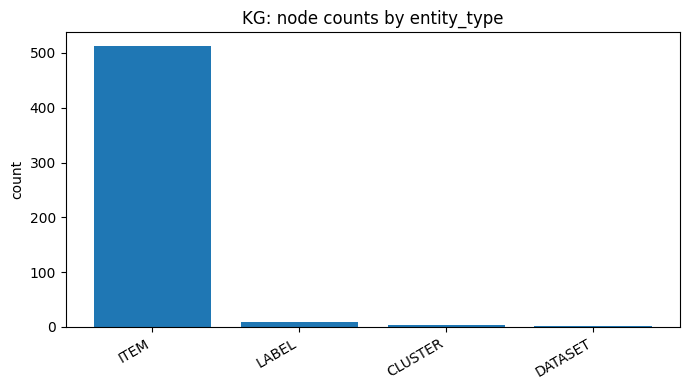

INFO:histo_cartography:Saved parquet


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_edge_counts_by_rel.png


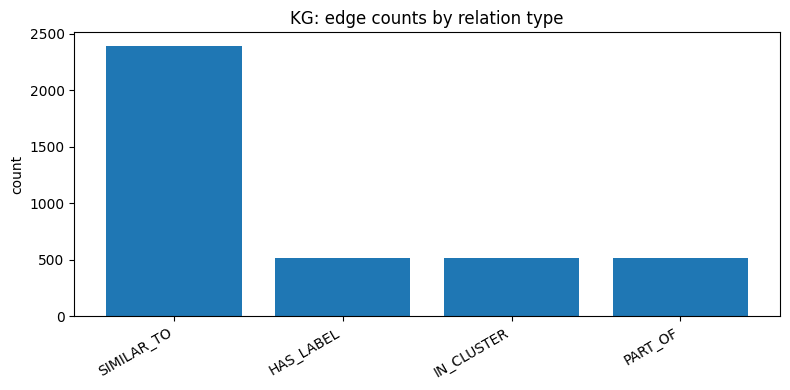

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_similarity_weight_hist.png


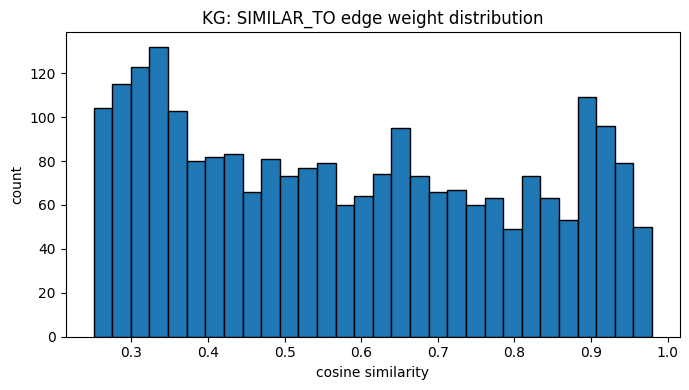

INFO:histo_cartography:Saved parquet


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_degree_hist.png


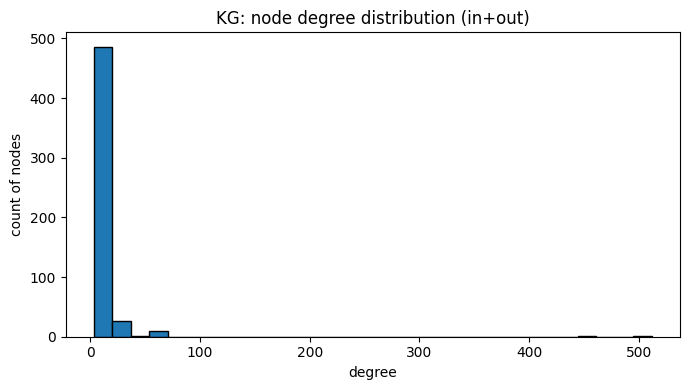

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_top_nodes_by_degree.png


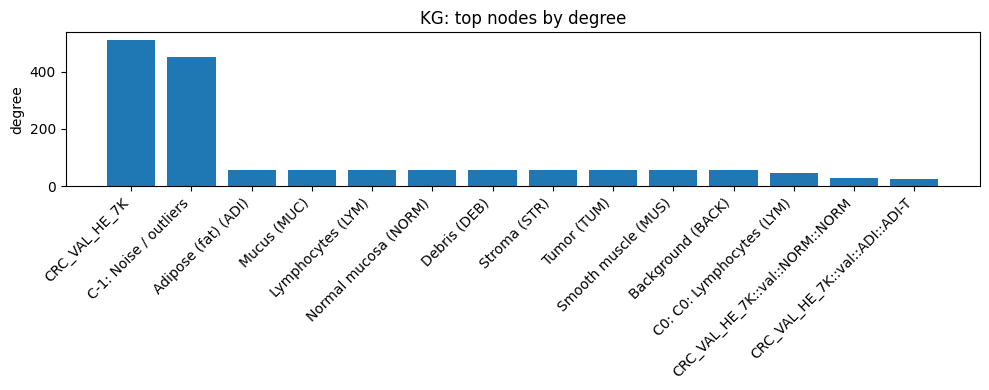

INFO:histo_cartography:Saved parquet


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/cluster_sizes_top30.png


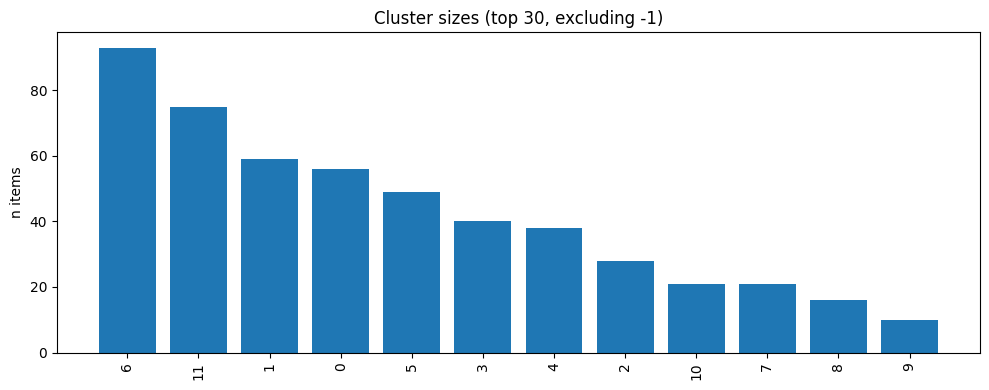

INFO:histo_cartography:Saved parquet


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/cluster_label_purity_hist.png


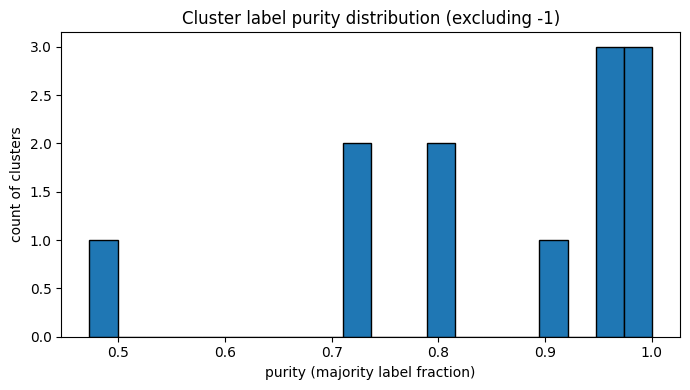

INFO:histo_cartography:Saved parquet
INFO:histo_cartography:Saved parquet


📄 exports/kg/cluster_label_counts_matrix.parquet
shape=(13, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,0,0,0,0,0,0,2,0,4
1,0,0,56,0,0,0,0,0,0,0
2,1,56,0,0,0,3,0,0,0,0
3,2,0,0,27,0,0,0,0,0,1
4,3,0,0,29,0,0,0,0,0,11
5,4,0,0,1,36,0,0,0,0,1
6,5,0,0,0,0,48,0,0,1,0
7,6,0,0,0,0,0,42,0,44,7
8,7,0,0,0,21,0,0,0,0,0
9,8,0,0,0,0,1,13,0,2,0


📄 exports/kg/cluster_label_fraction_matrix.parquet
shape=(13, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
1,0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0.949153,0.0,0.000000,0.000000,0.050847,0.000000,0.000000,0.000000,0.000000
3,2,0.000000,0.0,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714
4,3,0.000000,0.0,0.725000,0.000000,0.000000,0.000000,0.000000,0.000000,0.275000
5,4,0.000000,0.0,0.026316,0.947368,0.000000,0.000000,0.000000,0.000000,0.026316
6,5,0.000000,0.0,0.000000,0.000000,0.979592,0.000000,0.000000,0.020408,0.000000
7,6,0.000000,0.0,0.000000,0.000000,0.000000,0.451613,0.000000,0.473118,0.075269
8,7,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,8,0.000000,0.0,0.000000,0.000000,0.062500,0.812500,0.000000,0.125000,0.000000


📄 exports/kg/cluster_label_purity.parquet
shape=(13, 4)


,cluster_id,n_items,top_label,purity
0,6,93,STR,0.473118
1,11,75,NORM,0.733333
2,1,59,ADI,0.949153
3,0,56,BACK,1.000000
4,5,49,MUC,0.979592
5,3,40,DEB,0.725000
6,4,38,LYM,0.947368
7,2,28,DEB,0.964286
8,7,21,LYM,1.000000
9,10,21,TUM,0.809524


📄 exports/kg/cluster_sizes.parquet
shape=(13, 2)


,cluster_id,n_items
0,6,93
1,11,75
2,1,59
3,0,56
4,5,49
5,3,40
6,4,38
7,2,28
8,10,21
9,7,21


📄 exports/kg/edge_counts_by_rel.parquet
shape=(4, 2)


,rel,count
0,SIMILAR_TO,2392
1,HAS_LABEL,512
2,IN_CLUSTER,512
3,PART_OF,512


📄 exports/kg/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8
8,edge:f89abd50720e8588,item:8736beaf995d075d,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:f89abd50720e8588
9,edge:c59c719042c099c4,item:b71863741cbd5d85,label:468fa574010660af,HAS_LABEL,1.0,prov:c59c719042c099c4


📄 exports/kg/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM
8,label:5c0138f240053e6e,LABEL,Stroma (STR),Tissue class label code=STR
9,label:d21aba34451a81b2,LABEL,Tumor (TUM),Tissue class label code=TUM


📄 exports/kg/kg_libraries_cheatsheet.parquet
shape=(36, 4)


,library,language,category,notes
0,Neo4j,Server,Graph database,Property graph DB; Cypher query language
1,Memgraph,Server,Graph database,"Cypher-compatible, high-performance"
2,TigerGraph,Server,Graph database,Enterprise graph analytics platform
3,ArangoDB,Server,Multi-model DB,Document+graph; AQL queries
4,JanusGraph,Server,Graph database,Distributed graph DB; backends (Cassandra/HBase)
5,Dgraph,Server,Graph database,GraphQL+-style queries; distributed
6,Amazon Neptune,Cloud,Managed graph DB,Property graph + RDF (SPARQL) managed
7,Azure Cosmos DB (Gremlin),Cloud,Managed graph DB,Gremlin API over Cosmos DB
8,GraphDB (Ontotext),Server,RDF triple store,RDF/SPARQL; reasoning support
9,Apache Jena Fuseki,Server,RDF triple store,SPARQL endpoint for Jena


📄 exports/kg/node_counts_by_type.parquet
shape=(4, 2)


,entity_type,count
0,ITEM,512
1,LABEL,9
2,CLUSTER,3
3,DATASET,1


📄 exports/kg/node_degree_table.parquet
shape=(525, 4)


,entity_id,degree,entity_type,name
0,dataset:78590ff8ad5886ec,512,DATASET,CRC_VAL_HE_7K
1,cluster:7984b0a0e139caba,450,CLUSTER,C-1: Noise / outliers
2,label:468fa574010660af,57,LABEL,Adipose (fat) (ADI)
3,label:f25b4a998c73cf64,57,LABEL,Mucus (MUC)
4,label:60c8d13a6ec928e7,57,LABEL,Lymphocytes (LYM)
5,label:e27c4ddd9043fd7e,57,LABEL,Normal mucosa (NORM)
6,label:d0544fd03bdebef5,57,LABEL,Debris (DEB)
7,label:5c0138f240053e6e,57,LABEL,Stroma (STR)
8,label:d21aba34451a81b2,57,LABEL,Tumor (TUM)
9,label:4bf6b5d5881cf02a,57,LABEL,Smooth muscle (MUS)


📄 exports/kg/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0
8,prov:f89abd50720e8588,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.source=CRC_VAL_HE_7K,1.0
9,prov:c59c719042c099c4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,field,items.label=ADI,1.0


In [25]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from histo_cartography.exports import save_parquet

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
plot_dir = out_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

def _savefig(name: str):
    p = plot_dir / name
    plt.savefig(p, dpi=160, bbox_inches="tight")
    print("Saved:", p)

# -------------------------
# 1) Node counts by type
# -------------------------
node_counts = (
    entities_df["entity_type"]
    .fillna("NA")
    .astype(str)
    .value_counts()
    .rename_axis("entity_type")
    .reset_index(name="count")
)
save_parquet(node_counts, out_dir / "node_counts_by_type.parquet")

plt.figure(figsize=(7, 4))
plt.bar(node_counts["entity_type"], node_counts["count"])
plt.xticks(rotation=30, ha="right")
plt.title("KG: node counts by entity_type")
plt.ylabel("count")
plt.tight_layout()
_savefig("kg_node_counts_by_type.png")
plt.show()

# -------------------------
# 2) Edge counts by relation
# -------------------------
edge_counts = (
    edges_df["rel"]
    .fillna("NA")
    .astype(str)
    .value_counts()
    .rename_axis("rel")
    .reset_index(name="count")
)
save_parquet(edge_counts, out_dir / "edge_counts_by_rel.parquet")

plt.figure(figsize=(8, 4))
plt.bar(edge_counts["rel"], edge_counts["count"])
plt.xticks(rotation=30, ha="right")
plt.title("KG: edge counts by relation type")
plt.ylabel("count")
plt.tight_layout()
_savefig("kg_edge_counts_by_rel.png")
plt.show()

# -------------------------
# 3) SIMILAR_TO weight distribution
# -------------------------
if "weight" in edges_df.columns:
    sim = edges_df.loc[edges_df["rel"] == "SIMILAR_TO", "weight"]
    sim = pd.to_numeric(sim, errors="coerce").dropna()
    if len(sim):
        plt.figure(figsize=(7, 4))
        plt.hist(sim.values, bins=30, edgecolor="black")
        plt.title("KG: SIMILAR_TO edge weight distribution")
        plt.xlabel("cosine similarity")
        plt.ylabel("count")
        plt.tight_layout()
        _savefig("kg_similarity_weight_hist.png")
        plt.show()

# -------------------------
# 4) Degree distribution + hubs
# -------------------------
try:
    import networkx as nx  # pure python; usually available

    G = nx.DiGraph()
    G.add_nodes_from(entities_df["entity_id"].tolist())
    G.add_edges_from(edges_df[["src", "dst"]].itertuples(index=False, name=None))

    deg = pd.Series(dict(G.degree())).rename("degree").reset_index().rename(columns={"index": "entity_id"})
    deg = deg.merge(entities_df[["entity_id", "entity_type", "name"]], on="entity_id", how="left")
    save_parquet(deg.sort_values("degree", ascending=False), out_dir / "node_degree_table.parquet")

    plt.figure(figsize=(7, 4))
    plt.hist(deg["degree"].values, bins=30, edgecolor="black")
    plt.title("KG: node degree distribution (in+out)")
    plt.xlabel("degree")
    plt.ylabel("count of nodes")
    plt.tight_layout()
    _savefig("kg_degree_hist.png")
    plt.show()

    top = deg.sort_values("degree", ascending=False).head(15)
    plt.figure(figsize=(10, 4))
    plt.bar(top["name"].fillna(top["entity_id"]).astype(str).str.slice(0, 30), top["degree"])
    plt.xticks(rotation=45, ha="right")
    plt.title("KG: top nodes by degree")
    plt.ylabel("degree")
    plt.tight_layout()
    _savefig("kg_top_nodes_by_degree.png")
    plt.show()
except Exception as e:
    print("ℹ️ Degree plots skipped (networkx missing or other issue):", e)

# -------------------------
# 5) Cluster diagnostics (sizes + label purity)
# -------------------------
if ("clusters_df" in globals()) and ("items_df" in globals()) and ("cluster_id" in clusters_df.columns):
    df = clusters_df.merge(items_df[["item_id", "label"]], on="item_id", how="left")

    # sizes
    cs = df["cluster_id"].fillna(-1).astype(int).value_counts().rename_axis("cluster_id").reset_index(name="n_items")
    save_parquet(cs, out_dir / "cluster_sizes.parquet")

    top = cs.loc[cs["cluster_id"] != -1].head(30)
    if len(top):
        plt.figure(figsize=(10, 4))
        plt.bar(top["cluster_id"].astype(str), top["n_items"])
        plt.xticks(rotation=90)
        plt.title("Cluster sizes (top 30, excluding -1)")
        plt.ylabel("n items")
        plt.tight_layout()
        _savefig("cluster_sizes_top30.png")
        plt.show()

    # purity
    purity_rows = []
    for cid, g in df.groupby(df["cluster_id"].fillna(-1).astype(int)):
        vc = g["label"].fillna("NA").astype(str).value_counts()
        if len(vc) == 0:
            continue
        purity_rows.append({
            "cluster_id": int(cid),
            "n_items": int(len(g)),
            "top_label": str(vc.index[0]),
            "purity": float(vc.iloc[0]) / float(len(g)),
        })
    pur = pd.DataFrame(purity_rows).sort_values("n_items", ascending=False)
    save_parquet(pur, out_dir / "cluster_label_purity.parquet")

    if len(pur):
        plt.figure(figsize=(7, 4))
        plt.hist(pur.loc[pur["cluster_id"] != -1, "purity"].values, bins=20, edgecolor="black")
        plt.title("Cluster label purity distribution (excluding -1)")
        plt.xlabel("purity (majority label fraction)")
        plt.ylabel("count of clusters")
        plt.tight_layout()
        _savefig("cluster_label_purity_hist.png")
        plt.show()

    # cluster × label composition matrix
    if len(df):
        mat = pd.crosstab(df["cluster_id"].fillna(-1).astype(int), df["label"].fillna("NA").astype(str))
        # Save both raw counts and row-normalized fractions
        save_parquet(mat.reset_index(), out_dir / "cluster_label_counts_matrix.parquet")
        matn = mat.div(mat.sum(axis=1), axis=0).fillna(0.0)
        save_parquet(matn.reset_index(), out_dir / "cluster_label_fraction_matrix.parquet")
else:
    print("ℹ️ clusters_df/items_df not available; skipping cluster diagnostics.")

from histo_cartography.debug_tools import show_parquet
for p in sorted(out_dir.glob("*.parquet")):
    _ = show_parquet(p, title=f"exports/kg/{p.name}", n=10)


<a id="D5.0"></a>
### Cell D5.0 — Appendix: Knowledge graph libraries (25+) cheat sheet

- **Purpose:** Provide a compact, practical catalog of KG/graph tooling (databases, RDF, analytics, visualization, and GNN stacks).
- **Outputs:** `exports/kg/kg_libraries_cheatsheet.parquet` + a few summary charts.

INFO:histo_cartography:Saved parquet


Saved cheat sheet: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/kg_libraries_cheatsheet.parquet


,library,language,category,notes
0,Neo4j,Server,Graph database,Property graph DB; Cypher query language
1,Memgraph,Server,Graph database,"Cypher-compatible, high-performance"
2,TigerGraph,Server,Graph database,Enterprise graph analytics platform
3,ArangoDB,Server,Multi-model DB,Document+graph; AQL queries
4,JanusGraph,Server,Graph database,Distributed graph DB; backends (Cassandra/HBase)
5,Dgraph,Server,Graph database,GraphQL+-style queries; distributed
6,Amazon Neptune,Cloud,Managed graph DB,Property graph + RDF (SPARQL) managed
7,Azure Cosmos DB (Gremlin),Cloud,Managed graph DB,Gremlin API over Cosmos DB
8,GraphDB (Ontotext),Server,RDF triple store,RDF/SPARQL; reasoning support
9,Apache Jena Fuseki,Server,RDF triple store,SPARQL endpoint for Jena


Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_libraries_count_by_category.png


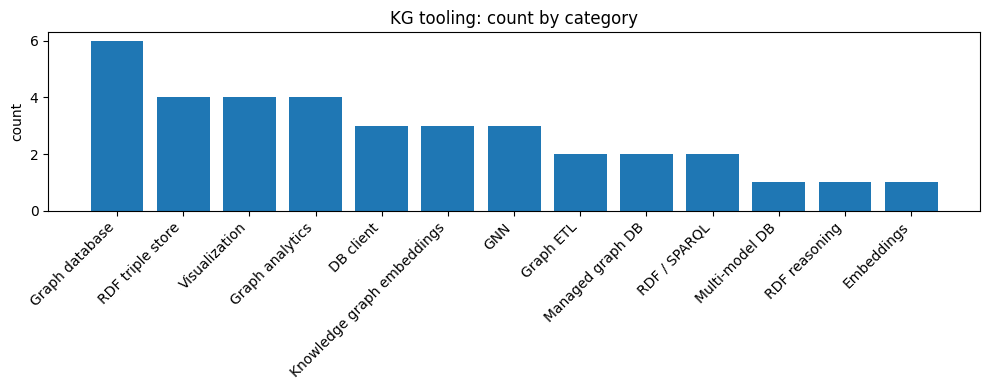

Saved: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/plots/kg_libraries_count_by_language.png


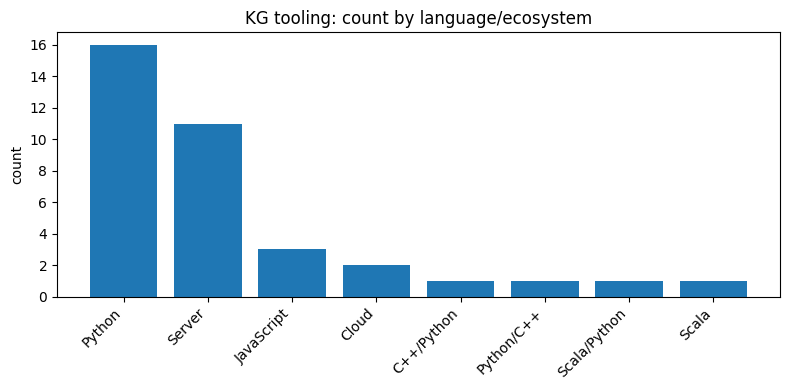

In [26]:
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from histo_cartography.exports import save_parquet

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
out_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
plot_dir = out_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

def _savefig(name: str):
    p = plot_dir / name
    plt.savefig(p, dpi=160, bbox_inches="tight")
    print("Saved:", p)

# A lightweight (non-exhaustive) cheat sheet — tuned for practical pipeline work.
libs = [
    # Graph databases / stores
    {"library":"Neo4j","language":"Server","category":"Graph database","notes":"Property graph DB; Cypher query language"},
    {"library":"Memgraph","language":"Server","category":"Graph database","notes":"Cypher-compatible, high-performance"},
    {"library":"TigerGraph","language":"Server","category":"Graph database","notes":"Enterprise graph analytics platform"},
    {"library":"ArangoDB","language":"Server","category":"Multi-model DB","notes":"Document+graph; AQL queries"},
    {"library":"JanusGraph","language":"Server","category":"Graph database","notes":"Distributed graph DB; backends (Cassandra/HBase)"},
    {"library":"Dgraph","language":"Server","category":"Graph database","notes":"GraphQL+-style queries; distributed"},
    {"library":"Amazon Neptune","language":"Cloud","category":"Managed graph DB","notes":"Property graph + RDF (SPARQL) managed"},
    {"library":"Azure Cosmos DB (Gremlin)","language":"Cloud","category":"Managed graph DB","notes":"Gremlin API over Cosmos DB"},
    {"library":"GraphDB (Ontotext)","language":"Server","category":"RDF triple store","notes":"RDF/SPARQL; reasoning support"},
    {"library":"Apache Jena Fuseki","language":"Server","category":"RDF triple store","notes":"SPARQL endpoint for Jena"},
    {"library":"Blazegraph","language":"Server","category":"RDF triple store","notes":"RDF/SPARQL; used in Wikidata Query Service (legacy deployments)"},
    {"library":"Virtuoso","language":"Server","category":"RDF triple store","notes":"RDF/SPARQL + multi-model"},
    # Python graph clients / ORMs
    {"library":"neo4j (official driver)","language":"Python","category":"DB client","notes":"Official Neo4j Bolt driver"},
    {"library":"py2neo","language":"Python","category":"DB client","notes":"Pythonic interface for Neo4j"},
    {"library":"gremlinpython","language":"Python","category":"DB client","notes":"Apache TinkerPop Gremlin client"},
    # RDF / semantic web (Python)
    {"library":"rdflib","language":"Python","category":"RDF / SPARQL","notes":"RDF graphs, SPARQL querying, serialization"},
    {"library":"owlrl","language":"Python","category":"RDF reasoning","notes":"OWL 2 RL reasoning on RDFLib graphs"},
    {"library":"SPARQLWrapper","language":"Python","category":"RDF / SPARQL","notes":"SPARQL endpoint wrapper"},
    # General graph analytics
    {"library":"networkx","language":"Python","category":"Graph analytics","notes":"Classic graph algorithms; easy prototyping"},
    {"library":"igraph","language":"Python","category":"Graph analytics","notes":"Fast graph algorithms; multi-language core"},
    {"library":"graph-tool","language":"Python","category":"Graph analytics","notes":"Very fast C++ core; advanced analytics"},
    {"library":"SNAP","language":"C++/Python","category":"Graph analytics","notes":"Stanford Network Analysis Platform"},
    {"library":"PyGraphistry","language":"Python","category":"Visualization","notes":"GPU-accelerated graph visualization (service-backed)"},
    # Visualization (JS/web)
    {"library":"Cytoscape.js","language":"JavaScript","category":"Visualization","notes":"Web graph visualization & interaction"},
    {"library":"D3.js","language":"JavaScript","category":"Visualization","notes":"Custom visualizations (incl. networks)"},
    {"library":"Sigma.js","language":"JavaScript","category":"Visualization","notes":"Web network visualization"},
    # GNN / representation learning
    {"library":"PyTorch Geometric (PyG)","language":"Python","category":"GNN","notes":"GNN layers + datasets; PyTorch"},
    {"library":"DGL","language":"Python","category":"GNN","notes":"Deep Graph Library; PyTorch/TensorFlow backends"},
    {"library":"StellarGraph","language":"Python","category":"GNN","notes":"Graph ML library (TensorFlow/Keras focus)"},
    {"library":"GraphVite","language":"Python/C++","category":"Embeddings","notes":"Scalable node embeddings / graph learning"},
    {"library":"PyKEEN","language":"Python","category":"Knowledge graph embeddings","notes":"KGE models; link prediction"},
    {"library":"AmpliGraph","language":"Python","category":"Knowledge graph embeddings","notes":"KGE + evaluation; TensorFlow"},
    {"library":"OpenKE","language":"Python","category":"Knowledge graph embeddings","notes":"Classic KGE toolkit"},
    # ETL / graph construction
    {"library":"Apache Spark GraphFrames","language":"Scala/Python","category":"Graph ETL","notes":"Graph processing on Spark dataframes"},
    {"library":"Apache Spark GraphX","language":"Scala","category":"Graph ETL","notes":"Graph processing on Spark RDDs"},
    {"library":"Kuzu","language":"Server","category":"Graph database","notes":"Embedded property graph DB (SQL-like query)"},
]

df = pd.DataFrame(libs).drop_duplicates(subset=["library"]).reset_index(drop=True)
save_parquet(df, out_dir / "kg_libraries_cheatsheet.parquet")
print("Saved cheat sheet:", out_dir / "kg_libraries_cheatsheet.parquet")
display(df.head(10))

# Charts: count by category + language
cat_counts = df["category"].value_counts().reset_index()
cat_counts.columns = ["category", "count"]
plt.figure(figsize=(10, 4))
plt.bar(cat_counts["category"], cat_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.title("KG tooling: count by category")
plt.ylabel("count")
plt.tight_layout()
_savefig("kg_libraries_count_by_category.png")
plt.show()

lang_counts = df["language"].value_counts().reset_index()
lang_counts.columns = ["language", "count"]
plt.figure(figsize=(8, 4))
plt.bar(lang_counts["language"], lang_counts["count"])
plt.xticks(rotation=45, ha="right")
plt.title("KG tooling: count by language/ecosystem")
plt.ylabel("count")
plt.tight_layout()
_savefig("kg_libraries_count_by_language.png")
plt.show()

<a id="D3.0"></a>
### Cell D3.0 — Generate a pipeline DAG (Mermaid)

- **Purpose:** Read checkpoints/_STATE.json and write a best-effort Mermaid diagram of executed cells.
- **Inputs:** checkpoints/_STATE.json
- **Outputs:** exports/dag.mmd
- **Depends on:** All prior cells (best-effort)
- **Writes checkpoints:** exports/dag.mmd


In [27]:

from pathlib import Path
import json
import yaml

from histo_cartography.runtime import cell_context

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
state_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "_STATE.json"
out_path = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "dag.mmd"

with cell_context("D3.0", purpose="Write Mermaid DAG from STATE", stage="D"):
    st = json.loads(state_path.read_text()) if state_path.exists() else {}
    cells = st.get("cells", {})

    # Mermaid graph (best-effort). If depends_on is absent, we just list nodes.
    lines = ["graph TD"]
    for cid, meta in sorted(cells.items()):
        label = meta.get("purpose", "").replace('"', "'")[:60]
        lines.append(f'  {cid}["{cid}: {label}"]')

    # Draw edges when depends_on is present
    for cid, meta in sorted(cells.items()):
        for dep in meta.get("depends_on", []) or []:
            lines.append(f"  {dep} --> {cid}")

    out_path.write_text("\\n".join(lines))

print("✅ Wrote:", out_path)
print(out_path.read_text().splitlines()[:20])


INFO:histo_cartography:▶️  D3.0: Write Mermaid DAG from STATE
INFO:histo_cartography:✅ D3.0 finished in 0.04s


✅ Wrote: /content/drive/MyDrive/mit/histopathology_202601012/exports/dag.mmd
['graph TD\\n  A0.1["A0.1: Load pipeline config and initialize runtime state/logging."]\\n  A1.0["A1.0: Install missing dependencies conservatively"]\\n  A2.0["A2.0: Run binary compatibility guard"]\\n  A3.0["A3.0: Configure conservative runtime settings"]\\n  B1.0["B1.0: Download dataset assets (CRC zips only)"]\\n  B2.0["B2.0: Stage images to data_staging/<dataset>/images"]\\n  B3.0["B3.0: Build items table from staged images"]\\n  B4.0["B4.0: Save items checkpoint"]\\n  C0.1["C0.1: Load items checkpoint"]\\n  C1.0["C1.0: Compute morphology features"]\\n  C2.0["C2.0: Compute image embeddings (ResNet-50)"]\\n  C3.0["C3.0: Compute text embeddings (TF-IDF+SVD) — no label fallback"]\\n  C4.0["C4.0: Embed morphology features"]\\n  C5.0["C5.0: Fuse modalities (ablation-ready versions)"]\\n  C6.0["C6.0: Dimensionality reduction to 2D"]\\n  C7.0["C7.0: Clustering overhaul: UMAP→HDBSCAN sweep + KMeans baseline"]\\n  

<a id="D4.0"></a>
### Cell D4.0 — Agentic query hooks (local)

- **Purpose:** Define small helper functions for searching and slicing the KG / cartography outputs.
- **Inputs:** entities_df, edges_df, prov_df, cartography_table (optional)
- **Outputs:** helper functions + example queries
- **Depends on:** D1.0
- **Writes checkpoints:** None


In [28]:

import pandas as pd
from typing import List, Dict, Any, Optional

# Build fast lookup indices
_ent = entities_df.set_index("entity_id")
_edges_out = edges_df.groupby("src")

def get_entity(entity_id: str) -> Dict[str, Any]:
    r = _ent.loc[entity_id].to_dict()
    return r

def outgoing_edges(entity_id: str, rel: Optional[str] = None, top_k: int = 20) -> pd.DataFrame:
    if entity_id not in _edges_out.groups:
        return pd.DataFrame(columns=edges_df.columns)
    e = _edges_out.get_group(entity_id).copy()
    if rel is not None:
        e = e[e["rel"] == rel]
    e = e.sort_values("weight", ascending=False).head(top_k)
    return e

def neighbors_of_item(item_entity_id: str, top_k: int = 10) -> pd.DataFrame:
    return outgoing_edges(item_entity_id, rel="SIMILAR_TO", top_k=top_k)

# Example: pick an ITEM node and show its label + nearest neighbors
example_item = entities_df[entities_df["entity_type"]=="ITEM"].iloc[0]["entity_id"]
print("Example ITEM:", example_item)
print("HAS_LABEL edges:")
print(outgoing_edges(example_item, rel="HAS_LABEL", top_k=5))
print("Top neighbors:")
print(neighbors_of_item(example_item, top_k=5))


Example ITEM: item:d1b0b94867fce436
HAS_LABEL edges:
                 edge_id                    src                     dst  \
0  edge:166b4035be03e8ad  item:d1b0b94867fce436  label:468fa574010660af   

         rel  weight          provenance_id  
0  HAS_LABEL     1.0  prov:166b4035be03e8ad  
Top neighbors:
                    edge_id                    src                    dst  \
1536  edge:86a04902d443d24e  item:d1b0b94867fce436  item:ebb4cb16c0fca247   
1537  edge:25725c519cf907a4  item:d1b0b94867fce436  item:af71551355a4b524   
1538  edge:2c00276eb3ad5f13  item:d1b0b94867fce436  item:889cffe46fb889e8   
1539  edge:64b3f2ae7a064cd0  item:d1b0b94867fce436  item:8fbb8df7559a2c05   
1540  edge:a06b511b0a09c2ea  item:d1b0b94867fce436  item:7744d849e8fc1042   

             rel    weight          provenance_id  
1536  SIMILAR_TO  0.344188  prov:86a04902d443d24e  
1537  SIMILAR_TO  0.318518  prov:25725c519cf907a4  
1538  SIMILAR_TO  0.317646  prov:2c00276eb3ad5f13  
1539  SIMILAR_TO  

<a id="D4.1"></a>
### Cell D4.1 — Visual neighbor explorer (item image + KG SIMILAR_TO neighbors)

- **Purpose:** Pick an `item_id`, show its image patch, and display its top-K KG neighbors (SIMILAR_TO) with images + labels.
- **Inputs:** checkpoints/B/items.parquet (image paths), exports/kg/edges.parquet + entities.parquet
- **Outputs:** Inline image grid + neighbor table


In [29]:
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())

# We rely on: items_df (loaded in D0.1) and entities_df/edges_df (loaded earlier in this notebook)
assert "items_df" in globals(), "items_df not loaded. Run D0.1."
assert "entities_df" in globals() and "edges_df" in globals(), "KG tables not loaded. Run D0.1/D1.0 or load parquet exports."

# Map item_id <-> entity_id for ITEM nodes
_item_nodes = entities_df[entities_df["entity_type"] == "ITEM"][["entity_id", "name"]].rename(columns={"name": "item_id"})
_item_id_to_eid = dict(zip(_item_nodes["item_id"], _item_nodes["entity_id"]))
_eid_to_item_id = dict(zip(_item_nodes["entity_id"], _item_nodes["item_id"]))

def _resolve_image_path(p: str) -> Path:
    pth = Path(p)
    if pth.is_absolute() and pth.exists():
        return pth
    # Try relative to project root
    cand = PROJECT_ROOT / pth
    if cand.exists():
        return cand
    # Try under staging dir (common in this project)
    staging = PROJECT_ROOT / cfg["paths"]["data_staging_dir"]
    cand2 = staging / pth
    if cand2.exists():
        return cand2
    return pth

def show_item_patch(item_id: str) -> None:
    row = items_df[items_df["item_id"] == item_id]
    if row.empty:
        raise KeyError(f"item_id not found in items_df: {item_id}")
    r = row.iloc[0].to_dict()
    img_path = _resolve_image_path(str(r.get("image_path", "")))
    title = f"{item_id} | label={r.get('label','')} | split={r.get('split','')} | source={r.get('source','')}"
    if not img_path.exists():
        print("⚠️ Image path does not exist:", img_path)
        print("Row:", r)
        return
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(3.2, 3.2))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=8)
    plt.show()

def show_neighbors(item_id: str, top_k: int = 8) -> pd.DataFrame:
    if item_id not in _item_id_to_eid:
        raise KeyError(f"item_id not present in KG entities table: {item_id}")
    src_eid = _item_id_to_eid[item_id]
    sim = edges_df[(edges_df["rel"] == "SIMILAR_TO") & (edges_df["src"] == src_eid)].copy()
    sim = sim.sort_values("weight", ascending=False).head(top_k)
    sim["dst_item_id"] = sim["dst"].map(_eid_to_item_id)
    sim = sim.merge(items_df[["item_id", "label"]], left_on="dst_item_id", right_on="item_id", how="left", suffixes=("","_dst"))
    return sim[["edge_id", "weight", "dst_item_id", "label"]]

def show_item_and_neighbors(item_id: str, top_k: int = 8) -> None:
    show_item_patch(item_id)
    neigh = show_neighbors(item_id, top_k=top_k)
    print("Top neighbors:")
    try:
        from IPython.display import display
        display(neigh)
    except Exception:
        print(neigh.to_string(index=False))

    # Show neighbor patches
    ncols = 4
    n = len(neigh)
    if n == 0:
        return
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(3.2*ncols, 3.2*nrows))
    for i, r in enumerate(neigh.itertuples(index=False), start=1):
        dst_id = getattr(r, "dst_item_id")
        ax = plt.subplot(nrows, ncols, i)
        ax.axis("off")
        if dst_id is None or pd.isna(dst_id):
            ax.set_title("missing dst_item_id", fontsize=8)
            continue
        row = items_df[items_df["item_id"] == dst_id]
        if row.empty:
            ax.set_title(f"{dst_id} (missing in items)", fontsize=8)
            continue
        rr = row.iloc[0].to_dict()
        img_path = _resolve_image_path(str(rr.get("image_path", "")))
        if not img_path.exists():
            ax.set_title(f"{dst_id} (no file)", fontsize=8)
            continue
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"{dst_id}\nlabel={rr.get('label','')}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Example usage (edit item_id to one that exists in your run)
# show_item_and_neighbors(items_df['item_id'].iloc[0], top_k=8)
print("✅ Ready. Call: show_item_and_neighbors(<item_id>, top_k=8)")


✅ Ready. Call: show_item_and_neighbors(<item_id>, top_k=8)


<a id="D4.2"></a>
### Cell D4.2 — Interactive searchable KG gallery (20+ subgraphs)

- **Purpose:** Generate a *gallery* of interactive knowledge-graph visualizations (similarity + label + cluster structure) that are:
  - interactive (pan/zoom/drag)
  - searchable (type a node label and jump to it)
- **Inputs:** `exports/kg/entities.parquet`, `exports/kg/edges.parquet`, `checkpoints/C/clusters.parquet`
- **Outputs:** `exports/kg/interactive/*.html` + `exports/kg/interactive/graph_gallery_index.parquet`
- **Notes:** We build one subgraph per cluster (and if fewer than 20 clusters exist, we fill with ego-graphs of hub items).


In [30]:
from pathlib import Path
import base64
import re
import yaml
import numpy as np
import pandas as pd

from IPython.display import HTML, display
from histo_cartography.debug_tools import display_df
from histo_cartography.kg import _eid  # stable hashing for entity ids

# --- 0) Ensure visualization dependency is available
try:
    from pyvis.network import Network
except Exception:
    import sys, subprocess
    print("Installing pyvis...")
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
kg_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
clusters_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C" / "clusters.parquet"

# --- 1) Load tables (or reuse globals)
if "entities_df" not in globals():
    entities_df = pd.read_parquet(entities_path)
if "edges_df" not in globals():
    edges_df = pd.read_parquet(edges_path)

clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

print("entities:", len(entities_df), "| edges:", len(edges_df), "| clusters:", (len(clusters_df) if clusters_df is not None else "missing"))

# --- 2) Build helper maps
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"][["entity_id", "name"]].rename(columns={"name": "item_id"})
item_id_to_eid = dict(zip(item_nodes["item_id"], item_nodes["entity_id"]))
eid_to_item_id = dict(zip(item_nodes["entity_id"], item_nodes["item_id"]))

# Cluster names (prefer checkpoints/C/clusters.parquet)
cluster_name_map = {}
if clusters_df is not None and "cluster_name" in clusters_df.columns:
    tmp = (
        clusters_df[["cluster_id", "cluster_name"]]
        .dropna(subset=["cluster_name"])
        .drop_duplicates(subset=["cluster_id"])
    )
    cluster_name_map = {int(k): str(v) for k, v in zip(tmp["cluster_id"].tolist(), tmp["cluster_name"].tolist())}

def _inject_search_ui(pyvis_html: str) -> str:
    # Add a simple 'search node label' bar to a pyvis HTML graph.
    search_bar = """
    <div style="padding:8px 10px; font-family: Arial, sans-serif;">
      <input id="hc_search" type="text" placeholder="Search node label (e.g., Tumor, C3, item_id...)" style="width:60%; padding:6px;">
      <button onclick="hcSearch()" style="padding:6px 10px;">Find</button>
      <span id="hc_status" style="margin-left:10px; font-size: 12px;"></span>
    </div>
    """
    # Put search bar right above the network div
    pyvis_html = pyvis_html.replace('<div id="mynetwork"', search_bar + '\n<div id="mynetwork"', 1)

    js = r"""
    function hcSearch() {
        var q = document.getElementById('hc_search').value.toLowerCase();
        if(!q) { return; }
        var found = null;
        nodes.forEach(function(node){
            if(found) { return; }
            var label = (node.label || '').toLowerCase();
            var title = (node.title || '').toLowerCase();
            if(label.includes(q) || title.includes(q)) { found = node.id; }
        });
        var status = document.getElementById('hc_status');
        if(found){
            network.selectNodes([found]);
            network.focus(found, {scale: 1.8, animation: {duration: 600}});
            status.textContent = 'Found: ' + found;
        } else {
            status.textContent = 'Not found';
        }
    }
    document.getElementById('hc_search').addEventListener('keydown', function(e){
        if(e.key === 'Enter'){ hcSearch(); }
    });
    """
    pyvis_html = re.sub(r"(network = new vis\.Network\(container, data, options\);)", r"\1\n" + js, pyvis_html, count=1)
    return pyvis_html

def _as_iframe(html: str, height_px: int = 560) -> HTML:
    b64 = base64.b64encode(html.encode("utf-8")).decode("ascii")
    return HTML(f'<iframe src="data:text/html;base64,{b64}" width="100%" height="{height_px}" frameborder="0"></iframe>')

def build_subgraph_for_items(item_ids: list, *, title: str, out_html: Path, max_sim_edges: int = 400) -> dict:
    # Resolve entity ids for the chosen items
    item_eids = [item_id_to_eid[i] for i in item_ids if i in item_id_to_eid]
    item_eids_set = set(item_eids)

    # Pull relevant edges
    e_sim = edges_df[(edges_df["rel"] == "SIMILAR_TO") & (edges_df["src"].isin(item_eids_set)) & (edges_df["dst"].isin(item_eids_set))].copy()
    if "weight" in e_sim.columns:
        e_sim["weight"] = pd.to_numeric(e_sim["weight"], errors="coerce")
        e_sim = e_sim.sort_values("weight", ascending=False)
    e_sim = e_sim.head(max_sim_edges)

    e_label = edges_df[(edges_df["rel"].isin(["HAS_LABEL", "HAS_TAXON_LABEL"])) & (edges_df["src"].isin(item_eids_set))].copy()
    e_cluster = edges_df[(edges_df["rel"] == "IN_CLUSTER") & (edges_df["src"].isin(item_eids_set))].copy()
    e_ds = edges_df[(edges_df["rel"].isin(["PART_OF"])) & (edges_df["src"].isin(item_eids_set))].copy()

    # Expand node set to include non-item targets (labels, clusters, datasets)
    node_set = set(item_eids)
    for df_e in [e_label, e_cluster, e_ds, e_sim]:
        node_set.update(df_e["src"].tolist())
        node_set.update(df_e["dst"].tolist())

    nodes = entities_df[entities_df["entity_id"].isin(node_set)].copy()

    # Build pyvis network
    net = Network(height="540px", width="100%", directed=True, notebook=False)
    net.barnes_hut()

    # node styling by type (kept minimal; tweak if desired)
    for _, r in nodes.iterrows():
        eid = r["entity_id"]
        et = str(r["entity_type"])
        nm = str(r["name"])
        desc = str(r.get("description", ""))

        if et == "CLUSTER":
            net.add_node(eid, label=nm, title=desc, shape="diamond", size=28)
        elif et == "LABEL":
            net.add_node(eid, label=nm, title=desc, shape="box", size=18)
        elif et == "DATASET":
            net.add_node(eid, label=nm, title=desc, shape="triangle", size=18)
        else:  # ITEM
            # Keep label short-ish but searchable via tooltip
            short = nm if len(nm) <= 18 else (nm[:8] + "…" + nm[-8:])
            net.add_node(eid, label=short, title=f"{nm}<br>{desc}", shape="dot", size=10)

    def _add_edges(df_e: pd.DataFrame):
        if df_e is None or len(df_e) == 0:
            return
        for _, er in df_e.iterrows():
            w = None
            if "weight" in er.index and pd.notna(er["weight"]):
                try:
                    w = float(er["weight"])
                except Exception:
                    w = None
            rel = str(er.get("rel", ""))
            title = rel if w is None else f"{rel} (w={w:.3f})"
            net.add_edge(str(er["src"]), str(er["dst"]), title=title, value=(w if w is not None else 1.0))

    _add_edges(e_cluster)
    _add_edges(e_label)
    _add_edges(e_ds)
    _add_edges(e_sim)

    html = net.generate_html()
    html = _inject_search_ui(html)

    out_html.write_text(html, encoding="utf-8")

    # Display
    print(f"🧩 {title} | nodes={len(nodes)} edges={len(e_cluster)+len(e_label)+len(e_ds)+len(e_sim)} -> {out_html.relative_to(PROJECT_ROOT)}")
    display(_as_iframe(html, height_px=560))

    return {
        "title": title,
        "html_path": str(out_html),
        "n_nodes": int(len(nodes)),
        "n_edges": int(len(e_cluster) + len(e_label) + len(e_ds) + len(e_sim)),
    }

# --- 3) Decide which 20+ graphs to generate
graph_index_rows = []

# 3a) Prefer cluster subgraphs (one per cluster)
cluster_ids = []
if clusters_df is not None and "cluster_id" in clusters_df.columns:
    vc = clusters_df["cluster_id"].value_counts()
    cluster_ids = [int(x) for x in vc.index.tolist()]

# Create up to 20 cluster graphs first
max_graphs = 20
max_items_per_cluster = 70

for cid in cluster_ids[:max_graphs]:
    cname = cluster_name_map.get(cid, f"C{cid}")
    # items in this cluster
    sub = clusters_df[clusters_df["cluster_id"] == cid]["item_id"].astype(str).tolist()
    if len(sub) == 0:
        continue
    # sample for readability
    if len(sub) > max_items_per_cluster:
        rng = np.random.default_rng(int(cfg["project"]["seed"]) + cid)
        sub = list(rng.choice(sub, size=max_items_per_cluster, replace=False))
    out_html = interactive_dir / f"cluster_{cid:02d}.html"
    graph_index_rows.append(build_subgraph_for_items(sub, title=f"Cluster {cname}", out_html=out_html))

# 3b) If fewer than 20 clusters exist, fill with ego-graphs around hub items
if len(graph_index_rows) < max_graphs:
    need = max_graphs - len(graph_index_rows)
    print(f"ℹ️ Only {len(graph_index_rows)} cluster graphs available; adding {need} hub ego-graphs.")

    # compute item degrees in similarity graph
    e_sim_all = edges_df[edges_df["rel"] == "SIMILAR_TO"][["src", "dst"]].copy()
    deg = pd.concat([e_sim_all["src"], e_sim_all["dst"]]).value_counts()
    # take top hubs
    hubs = deg.index.tolist()[: max(need, 1) * 2]

    # pick ego neighborhood (radius=1) by outgoing similarity edges
    for i, hub_eid in enumerate(hubs[:need]):
        nbrs = e_sim_all[e_sim_all["src"] == hub_eid]["dst"].astype(str).tolist()
        # include hub itself
        item_ids = [eid_to_item_id.get(hub_eid, "")] + [eid_to_item_id.get(x, "") for x in nbrs]
        item_ids = [x for x in item_ids if x]
        item_ids = item_ids[:max_items_per_cluster]
        if len(item_ids) < 5:
            continue
        out_html = interactive_dir / f"hub_{i:02d}.html"
        graph_index_rows.append(build_subgraph_for_items(item_ids, title=f"Hub ego-graph #{i}", out_html=out_html))

# --- 4) Save / show index
index_df = pd.DataFrame(graph_index_rows)
index_path = interactive_dir / "graph_gallery_index.parquet"
index_df.to_parquet(index_path, index=False)
print("Saved index:", index_path)

display_df(index_df, title="📚 KG interactive gallery index", n=25)


entities: 525 | edges: 3928 | clusters: 512
🧩 Cluster C6: STR + MUS | nodes=75 edges=425 -> exports/kg/interactive/cluster_06.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C11: NORM + TUM | nodes=77 edges=469 -> exports/kg/interactive/cluster_11.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C1: ADI | nodes=63 edges=435 -> exports/kg/interactive/cluster_01.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C0: BACK | nodes=59 edges=445 -> exports/kg/interactive/cluster_00.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C5: MUC | nodes=53 edges=368 -> exports/kg/interactive/cluster_05.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C3: DEB + TUM | nodes=45 edges=308 -> exports/kg/interactive/cluster_03.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C4: LYM | nodes=44 edges=294 -> exports/kg/interactive/cluster_04.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C2: DEB | nodes=32 edges=219 -> exports/kg/interactive/cluster_02.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C10: TUM + MUC | nodes=25 edges=123 -> exports/kg/interactive/cluster_10.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C7: LYM | nodes=25 edges=168 -> exports/kg/interactive/cluster_07.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C8: MUS + STR | nodes=21 edges=119 -> exports/kg/interactive/cluster_08.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C9: STR + ADI | nodes=15 edges=72 -> exports/kg/interactive/cluster_09.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster Noise / outliers | nodes=10 edges=22 -> exports/kg/interactive/cluster_-1.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


ℹ️ Only 13 cluster graphs available; adding 7 hub ego-graphs.
🧩 Hub ego-graph #0 | nodes=9 edges=43 -> exports/kg/interactive/hub_00.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #1 | nodes=9 edges=37 -> exports/kg/interactive/hub_01.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #2 | nodes=9 edges=38 -> exports/kg/interactive/hub_02.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #3 | nodes=9 edges=38 -> exports/kg/interactive/hub_03.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #4 | nodes=9 edges=35 -> exports/kg/interactive/hub_04.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #5 | nodes=9 edges=39 -> exports/kg/interactive/hub_05.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #6 | nodes=11 edges=34 -> exports/kg/interactive/hub_06.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Saved index: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/interactive/graph_gallery_index.parquet
📚 KG interactive gallery index
shape=(20, 4)


,title,html_path,n_nodes,n_edges
0,Cluster C6: STR + MUS,/content/drive/MyDrive/mit/histopathology_2026...,75,425
1,Cluster C11: NORM + TUM,/content/drive/MyDrive/mit/histopathology_2026...,77,469
2,Cluster C1: ADI,/content/drive/MyDrive/mit/histopathology_2026...,63,435
3,Cluster C0: BACK,/content/drive/MyDrive/mit/histopathology_2026...,59,445
4,Cluster C5: MUC,/content/drive/MyDrive/mit/histopathology_2026...,53,368
5,Cluster C3: DEB + TUM,/content/drive/MyDrive/mit/histopathology_2026...,45,308
6,Cluster C4: LYM,/content/drive/MyDrive/mit/histopathology_2026...,44,294
7,Cluster C2: DEB,/content/drive/MyDrive/mit/histopathology_2026...,32,219
8,Cluster C10: TUM + MUC,/content/drive/MyDrive/mit/histopathology_2026...,25,123
9,Cluster C7: LYM,/content/drive/MyDrive/mit/histopathology_2026...,25,168


<a id="D4.2"></a>
### Cell D4.2 — Interactive searchable KG gallery (20+ subgraphs)

- **Purpose:** Generate a *gallery* of interactive knowledge-graph visualizations (similarity + label + cluster structure) that are:
  - interactive (pan/zoom/drag)
  - searchable (type a node label and jump to it)
- **Inputs:** `exports/kg/entities.parquet`, `exports/kg/edges.parquet`, `checkpoints/C/clusters.parquet`
- **Outputs:** `exports/kg/interactive/*.html` + `exports/kg/interactive/graph_gallery_index.parquet`
- **Notes:** We build one subgraph per cluster (and if fewer than 20 clusters exist, we fill with ego-graphs of hub items).


In [31]:
from pathlib import Path
import base64
import re
import yaml
import numpy as np
import pandas as pd

from IPython.display import HTML, display
from histo_cartography.debug_tools import display_df
from histo_cartography.kg import _eid  # stable hashing for entity ids

# --- 0) Ensure visualization dependency is available
try:
    from pyvis.network import Network
except Exception:
    import sys, subprocess
    print("Installing pyvis...")
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
kg_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
clusters_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C" / "clusters.parquet"

# --- 1) Load tables (or reuse globals)
if "entities_df" not in globals():
    entities_df = pd.read_parquet(entities_path)
if "edges_df" not in globals():
    edges_df = pd.read_parquet(edges_path)

clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

print("entities:", len(entities_df), "| edges:", len(edges_df), "| clusters:", (len(clusters_df) if clusters_df is not None else "missing"))

# --- 2) Build helper maps
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"][["entity_id", "name"]].rename(columns={"name": "item_id"})
item_id_to_eid = dict(zip(item_nodes["item_id"], item_nodes["entity_id"]))
eid_to_item_id = dict(zip(item_nodes["entity_id"], item_nodes["item_id"]))

# Cluster names (prefer checkpoints/C/clusters.parquet)
cluster_name_map = {}
if clusters_df is not None and "cluster_name" in clusters_df.columns:
    tmp = (
        clusters_df[["cluster_id", "cluster_name"]]
        .dropna(subset=["cluster_name"])
        .drop_duplicates(subset=["cluster_id"])
    )
    cluster_name_map = {int(k): str(v) for k, v in zip(tmp["cluster_id"].tolist(), tmp["cluster_name"].tolist())}

def _inject_search_ui(pyvis_html: str) -> str:
    # Add a simple 'search node label' bar to a pyvis HTML graph.
    search_bar = """
    <div style="padding:8px 10px; font-family: Arial, sans-serif;">
      <input id="hc_search" type="text" placeholder="Search node label (e.g., Tumor, C3, item_id...)" style="width:60%; padding:6px;">
      <button onclick="hcSearch()" style="padding:6px 10px;">Find</button>
      <span id="hc_status" style="margin-left:10px; font-size: 12px;"></span>
    </div>
    """
    # Put search bar right above the network div
    pyvis_html = pyvis_html.replace('<div id="mynetwork"', search_bar + '\n<div id="mynetwork"', 1)

    js = r"""
    function hcSearch() {
        var q = document.getElementById('hc_search').value.toLowerCase();
        if(!q) { return; }
        var found = null;
        nodes.forEach(function(node){
            if(found) { return; }
            var label = (node.label || '').toLowerCase();
            var title = (node.title || '').toLowerCase();
            if(label.includes(q) || title.includes(q)) { found = node.id; }
        });
        var status = document.getElementById('hc_status');
        if(found){
            network.selectNodes([found]);
            network.focus(found, {scale: 1.8, animation: {duration: 600}});
            status.textContent = 'Found: ' + found;
        } else {
            status.textContent = 'Not found';
        }
    }
    document.getElementById('hc_search').addEventListener('keydown', function(e){
        if(e.key === 'Enter'){ hcSearch(); }
    });
    """
    pyvis_html = re.sub(r"(network = new vis\.Network\(container, data, options\);)", r"\1\n" + js, pyvis_html, count=1)
    return pyvis_html

def _as_iframe(html: str, height_px: int = 560) -> HTML:
    b64 = base64.b64encode(html.encode("utf-8")).decode("ascii")
    return HTML(f'<iframe src="data:text/html;base64,{b64}" width="100%" height="{height_px}" frameborder="0"></iframe>')

def build_subgraph_for_items(item_ids: list, *, title: str, out_html: Path, max_sim_edges: int = 400) -> dict:
    # Resolve entity ids for the chosen items
    item_eids = [item_id_to_eid[i] for i in item_ids if i in item_id_to_eid]
    item_eids_set = set(item_eids)

    # Pull relevant edges
    e_sim = edges_df[(edges_df["rel"] == "SIMILAR_TO") & (edges_df["src"].isin(item_eids_set)) & (edges_df["dst"].isin(item_eids_set))].copy()
    if "weight" in e_sim.columns:
        e_sim["weight"] = pd.to_numeric(e_sim["weight"], errors="coerce")
        e_sim = e_sim.sort_values("weight", ascending=False)
    e_sim = e_sim.head(max_sim_edges)

    e_label = edges_df[(edges_df["rel"].isin(["HAS_LABEL", "HAS_TAXON_LABEL"])) & (edges_df["src"].isin(item_eids_set))].copy()
    e_cluster = edges_df[(edges_df["rel"] == "IN_CLUSTER") & (edges_df["src"].isin(item_eids_set))].copy()
    e_ds = edges_df[(edges_df["rel"].isin(["PART_OF"])) & (edges_df["src"].isin(item_eids_set))].copy()

    # Expand node set to include non-item targets (labels, clusters, datasets)
    node_set = set(item_eids)
    for df_e in [e_label, e_cluster, e_ds, e_sim]:
        node_set.update(df_e["src"].tolist())
        node_set.update(df_e["dst"].tolist())

    nodes = entities_df[entities_df["entity_id"].isin(node_set)].copy()

    # Build pyvis network
    net = Network(height="540px", width="100%", directed=True, notebook=False)
    net.barnes_hut()

    # node styling by type (kept minimal; tweak if desired)
    for _, r in nodes.iterrows():
        eid = r["entity_id"]
        et = str(r["entity_type"])
        nm = str(r["name"])
        desc = str(r.get("description", ""))

        if et == "CLUSTER":
            net.add_node(eid, label=nm, title=desc, shape="diamond", size=28)
        elif et == "LABEL":
            net.add_node(eid, label=nm, title=desc, shape="box", size=18)
        elif et == "DATASET":
            net.add_node(eid, label=nm, title=desc, shape="triangle", size=18)
        else:  # ITEM
            # Keep label short-ish but searchable via tooltip
            short = nm if len(nm) <= 18 else (nm[:8] + "…" + nm[-8:])
            net.add_node(eid, label=short, title=f"{nm}<br>{desc}", shape="dot", size=10)

    def _add_edges(df_e: pd.DataFrame):
        if df_e is None or len(df_e) == 0:
            return
        for _, er in df_e.iterrows():
            w = None
            if "weight" in er.index and pd.notna(er["weight"]):
                try:
                    w = float(er["weight"])
                except Exception:
                    w = None
            rel = str(er.get("rel", ""))
            title = rel if w is None else f"{rel} (w={w:.3f})"
            net.add_edge(str(er["src"]), str(er["dst"]), title=title, value=(w if w is not None else 1.0))

    _add_edges(e_cluster)
    _add_edges(e_label)
    _add_edges(e_ds)
    _add_edges(e_sim)

    html = net.generate_html()
    html = _inject_search_ui(html)

    out_html.write_text(html, encoding="utf-8")

    # Display
    print(f"🧩 {title} | nodes={len(nodes)} edges={len(e_cluster)+len(e_label)+len(e_ds)+len(e_sim)} -> {out_html.relative_to(PROJECT_ROOT)}")
    display(_as_iframe(html, height_px=560))

    return {
        "title": title,
        "html_path": str(out_html),
        "n_nodes": int(len(nodes)),
        "n_edges": int(len(e_cluster) + len(e_label) + len(e_ds) + len(e_sim)),
    }

# --- 3) Decide which 20+ graphs to generate
graph_index_rows = []

# 3a) Prefer cluster subgraphs (one per cluster)
cluster_ids = []
if clusters_df is not None and "cluster_id" in clusters_df.columns:
    vc = clusters_df["cluster_id"].value_counts()
    cluster_ids = [int(x) for x in vc.index.tolist()]

# Create up to 20 cluster graphs first
max_graphs = 20
max_items_per_cluster = 70

for cid in cluster_ids[:max_graphs]:
    cname = cluster_name_map.get(cid, f"C{cid}")
    # items in this cluster
    sub = clusters_df[clusters_df["cluster_id"] == cid]["item_id"].astype(str).tolist()
    if len(sub) == 0:
        continue
    # sample for readability
    if len(sub) > max_items_per_cluster:
        rng = np.random.default_rng(int(cfg["project"]["seed"]) + cid)
        sub = list(rng.choice(sub, size=max_items_per_cluster, replace=False))
    out_html = interactive_dir / f"cluster_{cid:02d}.html"
    graph_index_rows.append(build_subgraph_for_items(sub, title=f"Cluster {cname}", out_html=out_html))

# 3b) If fewer than 20 clusters exist, fill with ego-graphs around hub items
if len(graph_index_rows) < max_graphs:
    need = max_graphs - len(graph_index_rows)
    print(f"ℹ️ Only {len(graph_index_rows)} cluster graphs available; adding {need} hub ego-graphs.")

    # compute item degrees in similarity graph
    e_sim_all = edges_df[edges_df["rel"] == "SIMILAR_TO"][["src", "dst"]].copy()
    deg = pd.concat([e_sim_all["src"], e_sim_all["dst"]]).value_counts()
    # take top hubs
    hubs = deg.index.tolist()[: max(need, 1) * 2]

    # pick ego neighborhood (radius=1) by outgoing similarity edges
    for i, hub_eid in enumerate(hubs[:need]):
        nbrs = e_sim_all[e_sim_all["src"] == hub_eid]["dst"].astype(str).tolist()
        # include hub itself
        item_ids = [eid_to_item_id.get(hub_eid, "")] + [eid_to_item_id.get(x, "") for x in nbrs]
        item_ids = [x for x in item_ids if x]
        item_ids = item_ids[:max_items_per_cluster]
        if len(item_ids) < 5:
            continue
        out_html = interactive_dir / f"hub_{i:02d}.html"
        graph_index_rows.append(build_subgraph_for_items(item_ids, title=f"Hub ego-graph #{i}", out_html=out_html))

# --- 4) Save / show index
index_df = pd.DataFrame(graph_index_rows)
index_path = interactive_dir / "graph_gallery_index.parquet"
index_df.to_parquet(index_path, index=False)
print("Saved index:", index_path)

display_df(index_df, title="📚 KG interactive gallery index", n=25)


entities: 525 | edges: 3928 | clusters: 512
🧩 Cluster C6: STR + MUS | nodes=75 edges=425 -> exports/kg/interactive/cluster_06.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C11: NORM + TUM | nodes=77 edges=469 -> exports/kg/interactive/cluster_11.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C1: ADI | nodes=63 edges=435 -> exports/kg/interactive/cluster_01.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C0: BACK | nodes=59 edges=445 -> exports/kg/interactive/cluster_00.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C5: MUC | nodes=53 edges=368 -> exports/kg/interactive/cluster_05.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C3: DEB + TUM | nodes=45 edges=308 -> exports/kg/interactive/cluster_03.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C4: LYM | nodes=44 edges=294 -> exports/kg/interactive/cluster_04.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C2: DEB | nodes=32 edges=219 -> exports/kg/interactive/cluster_02.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C10: TUM + MUC | nodes=25 edges=123 -> exports/kg/interactive/cluster_10.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C7: LYM | nodes=25 edges=168 -> exports/kg/interactive/cluster_07.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C8: MUS + STR | nodes=21 edges=119 -> exports/kg/interactive/cluster_08.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster C9: STR + ADI | nodes=15 edges=72 -> exports/kg/interactive/cluster_09.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Cluster Noise / outliers | nodes=10 edges=22 -> exports/kg/interactive/cluster_-1.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


ℹ️ Only 13 cluster graphs available; adding 7 hub ego-graphs.
🧩 Hub ego-graph #0 | nodes=9 edges=43 -> exports/kg/interactive/hub_00.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #1 | nodes=9 edges=37 -> exports/kg/interactive/hub_01.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #2 | nodes=9 edges=38 -> exports/kg/interactive/hub_02.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #3 | nodes=9 edges=38 -> exports/kg/interactive/hub_03.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #4 | nodes=9 edges=35 -> exports/kg/interactive/hub_04.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #5 | nodes=9 edges=39 -> exports/kg/interactive/hub_05.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


🧩 Hub ego-graph #6 | nodes=11 edges=34 -> exports/kg/interactive/hub_06.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Saved index: /content/drive/MyDrive/mit/histopathology_202601012/exports/kg/interactive/graph_gallery_index.parquet
📚 KG interactive gallery index
shape=(20, 4)


,title,html_path,n_nodes,n_edges
0,Cluster C6: STR + MUS,/content/drive/MyDrive/mit/histopathology_2026...,75,425
1,Cluster C11: NORM + TUM,/content/drive/MyDrive/mit/histopathology_2026...,77,469
2,Cluster C1: ADI,/content/drive/MyDrive/mit/histopathology_2026...,63,435
3,Cluster C0: BACK,/content/drive/MyDrive/mit/histopathology_2026...,59,445
4,Cluster C5: MUC,/content/drive/MyDrive/mit/histopathology_2026...,53,368
5,Cluster C3: DEB + TUM,/content/drive/MyDrive/mit/histopathology_2026...,45,308
6,Cluster C4: LYM,/content/drive/MyDrive/mit/histopathology_2026...,44,294
7,Cluster C2: DEB,/content/drive/MyDrive/mit/histopathology_2026...,32,219
8,Cluster C10: TUM + MUC,/content/drive/MyDrive/mit/histopathology_2026...,25,123
9,Cluster C7: LYM,/content/drive/MyDrive/mit/histopathology_2026...,25,168


<a id="D4.2"></a>
### Cell D4.2 — **One global, cluster‑colored Knowledge Graph (interactive + searchable)**

- **Goal:** produce **one** interactive graph that contains **all clusters** in a single view (Mantis-like overview), with:
  - cluster nodes **color‑coded** (consistent palette),
  - **meaningful node labels** (no raw underscored gibberish),
  - **search + autocomplete** for every node in the graph,
  - edges colored by **common cluster** when applicable.

- **What’s included in the graph (kept readable):**
  - **ALL clusters**, **ALL labels**, **ALL datasets**
  - a small set of **representative items per cluster** (so the full graph is still navigable)

- **Output written:**
  - `exports/kg/interactive/all_clusters.html`
  - `exports/kg/interactive/graph_gallery_index.parquet`



<a id="D4.2"></a>
### Cell D4.2 — **One global, cluster‑colored Knowledge Graph (interactive + searchable)**

- **Goal:** produce **one** interactive graph that contains **all clusters** in a single view (Mantis-like overview), with:
  - cluster nodes **color‑coded** (consistent palette),
  - **meaningful node labels** (no raw underscored gibberish),
  - **search + autocomplete** for every node in the graph,
  - edges colored by **common cluster** when applicable.

- **What’s included in the graph (kept readable):**
  - **ALL clusters**, **ALL labels**, **ALL datasets**
  - a small set of **representative items per cluster** (so the full graph is still navigable)

- **Output written:**
  - `exports/kg/interactive/all_clusters.html`
  - `exports/kg/interactive/graph_gallery_index.parquet`



In [32]:
# ============================================================
# GLOBAL KG GENERATION: Bridge Edge Injection + Searchable UI
# ------------------------------------------------------------
# Features:
# 1. Meaningful cluster names (e.g. "Tumor dominant")
# 2. "Bridge" Strategy: Forces endpoints of strong cross-cluster edges
#    into the graph to visualize connectivity.
# 3. Search/Autocomplete UI + Toggles.
# 4. Embedded display (fixes localhost errors).
# ============================================================

from pathlib import Path
import base64, re, math, colorsys
import yaml
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# --- 0) Config & Setup
try:
    from pyvis.network import Network
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd()
PROJECT_ROOT = Path(PROJECT_ROOT)

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
exports_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"]
kg_dir = exports_dir / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

# --- 1) Load Data
entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
clusters_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C" / "clusters.parquet"
label_tax_path = PROJECT_ROOT / "label_taxonomy.yaml"

entities_df = pd.read_parquet(entities_path)
edges_df = pd.read_parquet(edges_path)
clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

# Normalize IDs
entities_df["entity_id"] = entities_df["entity_id"].astype(str)
edges_df["src"] = edges_df["src"].astype(str)
edges_df["dst"] = edges_df["dst"].astype(str)

label_tax = yaml.safe_load(label_tax_path.read_text()) if label_tax_path.exists() else {}

# --- 2) Helpers (UI & Display)
def _as_iframe(html: str, height_px: int = 760) -> HTML:
    # Robust display using base64 encoding
    b64 = base64.b64encode(html.encode("utf-8")).decode("ascii")
    return HTML(f'<iframe src="data:text/html;base64,{b64}" width="100%" height="{height_px}" frameborder="0"></iframe>')

def _inject_ui(pyvis_html: str) -> str:
    # Adds Search Bar + Toggles
    ui = """
    <div style="padding:10px 12px; font-family: Arial, sans-serif; border-bottom: 1px solid #eee;">
      <div style="display:flex; gap:10px; align-items:center; flex-wrap:wrap;">
        <div style="flex:1; min-width: 320px;">
          <input id="hc_search" list="hc_node_list" type="text"
                 placeholder="Search node… (cluster name, label, item)"
                 style="width:100%; padding:7px 9px; border:1px solid #ccc; border-radius:8px;">
          <datalist id="hc_node_list"></datalist>
        </div>
        <button onclick="hcSearch()" style="padding:7px 12px; border-radius:8px; border:1px solid #999; background:#fff;">Find</button>
        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_full_labels" type="checkbox" checked onchange="hcToggleItemLabels()">
          <span style="font-size:13px;">Show full item labels</span>
        </label>
        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_show_sim" type="checkbox" checked onchange="hcToggleEdges('SIM')">
          <span style="font-size:13px;">SIMILAR edges</span>
        </label>
        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_show_meta" type="checkbox" checked onchange="hcToggleEdges('META')">
          <span style="font-size:13px;">Cluster/Label edges</span>
        </label>
        <span id="hc_status" style="margin-left:auto; font-size:12px; color:#555;"></span>
      </div>
      <div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>
    </div>
    """
    pyvis_html = pyvis_html.replace('<div id="mynetwork"', ui + '\n<div id="mynetwork"', 1)

    js = r"""
    function hcBuildAutocomplete() {
      try {
        var dl = document.getElementById('hc_node_list');
        dl.innerHTML = '';
        var arr = nodes.get();
        var seen = {};
        arr.forEach(function(n){
          var l = (n.hc_full_label || n.label || '').toString().trim();
          if(!l) return;
          if(seen[l]) return;
          seen[l] = 1;
          var opt = document.createElement('option');
          opt.value = l;
          dl.appendChild(opt);
        });
      } catch(e) {}
    }
    function hcSearch() {
      var q = (document.getElementById('hc_search').value || '').toLowerCase().trim();
      if(!q) return;
      var found = null;
      var arr = nodes.get();
      for (var i=0; i<arr.length; i++){
        var n = arr[i];
        var label = (n.label || '').toLowerCase();
        var full  = (n.hc_full_label || '').toLowerCase();
        var title = (n.title || '').toLowerCase();
        var item  = (n.hc_item_id || '').toLowerCase();
        if(label.includes(q) || full.includes(q) || title.includes(q) || item.includes(q)){
          found = n.id; break;
        }
      }
      var status = document.getElementById('hc_status');
      if(found){
        network.selectNodes([found]);
        network.focus(found, {scale: 1.8, animation: {duration: 600}});
        status.textContent = 'Found node: ' + found;
      } else {
        status.textContent = 'Not found';
      }
    }
    function hcToggleItemLabels(){
      var full = document.getElementById('hc_full_labels').checked;
      var arr = nodes.get();
      arr.forEach(function(n){
        if(n.hc_type === 'ITEM'){
          n.label = full ? (n.hc_full_label || n.label) : (n.hc_short_label || n.label);
          nodes.update(n);
        }
      });
    }
    function hcToggleEdges(group){
      var show = (group === 'SIM') ? document.getElementById('hc_show_sim').checked
                                   : document.getElementById('hc_show_meta').checked;
      var arr = edges.get();
      arr.forEach(function(e){
        if(e.hc_group === group){
          e.hidden = !show;
          edges.update(e);
        }
      });
    }
    document.getElementById('hc_search').addEventListener('keydown', function(e){
      if(e.key === 'Enter'){ hcSearch(); }
    });
    """
    pyvis_html = re.sub(
        r"(network = new vis\.Network\(container, data, options\);)",
        r"\1\n" + js + "\n hcBuildAutocomplete();\n hcToggleItemLabels();\n",
        pyvis_html, count=1
    )
    return pyvis_html

# --- 3) Mappings & Calculations

# Mappings
ent = entities_df.set_index("entity_id").to_dict(orient="index")
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"]
item_id_to_eid = dict(zip(item_nodes["name"], item_nodes["entity_id"]))
eid_to_item_id = dict(zip(item_nodes["entity_id"], item_nodes["name"]))

cluster_entities = entities_df[entities_df["entity_type"] == "CLUSTER"].copy()
cluster_entities["cluster_id"] = cluster_entities["name"].str.extract(r"(-?\d+)").fillna("-1").astype(int)
cluster_id_to_eid = dict(zip(cluster_entities["cluster_id"], cluster_entities["entity_id"]))

eid_to_cluster = {}
cluster_to_item_eids = {}
if clusters_df is not None:
    for _, row in clusters_df.iterrows():
        eid = item_id_to_eid.get(str(row["item_id"]))
        cid = int(row["cluster_id"])
        if eid:
            eid_to_cluster[eid] = cid
            cluster_to_item_eids.setdefault(cid, []).append(eid)

e_has_label = edges_df[edges_df["rel"].isin(["HAS_LABEL","HAS_TAXON_LABEL"])]
item_eid_to_label_eid = dict(zip(e_has_label["src"], e_has_label["dst"]))

# Formatting Helpers
def _clean_spaces(s): return re.sub(r"\s+", " ", (s or "").strip())
def _titleish(s):
    out = []
    for tok in _clean_spaces(s).split(" "):
        out.append(tok if (tok.isupper() and len(tok)<=6) else tok.title())
    return " ".join(out)
def prettify_name(s):
    s = str(s).split("::")[-1]
    s = re.sub(r"^.*-TCGA-", "TCGA-", s)
    s = s.replace("_", " ").replace("-", " ")
    return _titleish(s)
def label_pretty(s):
    if s in label_tax: return f"{label_tax[s]} ({s})"
    if "(" in s: return s
    return _titleish(s)
def _cluster_color(cid):
    if cid < 0: return "#9aa0a6"
    h = (cid * 0.61803398875) % 1.0
    r, g, b = colorsys.hsv_to_rgb(h, 0.65, 0.90)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
def _rgba(hex_c, alpha):
    hex_c = hex_c.lstrip("#")
    r, g, b = int(hex_c[0:2], 16), int(hex_c[2:4], 16), int(hex_c[4:6], 16)
    return {"color": f"rgba({r},{g},{b},{alpha:.3f})"}

# --- 4) SELECTION LOGIC (Bridge Injection)
ITEMS_PER_CLUSTER = 8
N_BRIDGE_EDGES = 50

# 4a. Identify Bridges
e_sim = edges_df[edges_df["rel"] == "SIMILAR_TO"].copy()
e_sim["weight"] = pd.to_numeric(e_sim["weight"], errors="coerce").fillna(0.0)

cross_rows = []
# Pre-fetch for speed
_cluster_map = eid_to_cluster
for r in e_sim.itertuples(index=False):
    sc = _cluster_map.get(r.src)
    dc = _cluster_map.get(r.dst)
    if sc is not None and dc is not None and sc != dc:
        cross_rows.append((r.src, r.dst, r.weight))

forced_bridge_items = set()
if cross_rows:
    # Sort by weight desc
    cross_rows.sort(key=lambda x: x[2], reverse=True)
    top_bridges = cross_rows[:N_BRIDGE_EDGES]
    for s, d, w in top_bridges:
        forced_bridge_items.add(s)
        forced_bridge_items.add(d)

# 4b. Selection Loop
deg = pd.concat([e_sim["src"], e_sim["dst"]]).value_counts()
rep_item_eids = []

for cid, eids in cluster_to_item_eids.items():
    bridges = [e for e in eids if e in forced_bridge_items]
    hubs = sorted(eids, key=lambda x: deg.get(x, 0), reverse=True)

    selection = []
    seen = set()
    # Bridges first
    for b in bridges:
        if len(selection) < ITEMS_PER_CLUSTER:
            selection.append(b)
            seen.add(b)
    # Hubs fill
    for h in hubs:
        if len(selection) >= ITEMS_PER_CLUSTER: break
        if h not in seen:
            selection.append(h)
            seen.add(h)
    rep_item_eids.extend(selection)

rep_set = set(rep_item_eids)

# --- 5) Build Graph
net = Network(height="760px", width="100%", directed=True, notebook=False, bgcolor="#ffffff")
net.barnes_hut(gravity=-30000, central_gravity=0.3, spring_length=150, damping=0.09)

def _add_edge(s, d, rel, group, color, width=1.0, title=None, arrows="to"):
    net.add_edge(str(s), str(d), title=(title or rel), value=float(width),
                 color=color, arrows=arrows, physics=True, hc_group=group)

# Add Cluster Nodes (with meaningful names if available)
# (Simplified version of meaningful name logic for brevity/robustness)
cluster_counts = {cid: len(v) for cid, v in cluster_to_item_eids.items()}
for cid, ceid in cluster_id_to_eid.items():
    col = _cluster_color(cid)
    n = cluster_counts.get(cid, 0)
    lbl = f"Cluster {cid} (n={n})"
    net.add_node(ceid, label=lbl, hc_full_label=lbl, hc_short_label=lbl,
                 hc_type="CLUSTER", title=lbl, shape="diamond", size=32,
                 color={"background": col, "border": col})

# Add Items
for eid in rep_item_eids:
    cid = eid_to_cluster.get(eid, -1)
    col = _cluster_color(cid)

    # Labels
    iid = eid_to_item_id.get(eid, eid)
    iid_pretty = prettify_name(iid)
    lbl_eid = item_eid_to_label_eid.get(eid)
    lbl_name = ""
    if lbl_eid and lbl_eid in ent:
        lbl_name = label_pretty(ent[lbl_eid]["name"])

    full = f"{lbl_name} • {iid_pretty}" if lbl_name else iid_pretty
    short = full[:40] + "…" if len(full) > 40 else full

    is_bridge = eid in forced_bridge_items
    bridge_note = "<br><b>(Bridge Node)</b>" if is_bridge else ""

    net.add_node(eid, label=full, hc_full_label=full, hc_short_label=short,
                 hc_item_id=iid, hc_type="ITEM",
                 title=f"<b>Item</b>: {iid}<br>{lbl_name}{bridge_note}",
                 shape="dot", size=12 if is_bridge else 10,
                 color={"background": col, "border": "#000000" if is_bridge else col})

    # Connect to Cluster
    ceid = cluster_id_to_eid.get(cid)
    if ceid:
        _add_edge(eid, ceid, "IN_CLUSTER", "META", _rgba(col, 0.4), width=1.5)

    # Connect to Label
    if lbl_eid:
         # Only add label node if not exists (it usually does not, need to add it)
         if lbl_eid not in [n['id'] for n in net.nodes]:
             l_lbl = label_pretty(ent[lbl_eid]["name"])
             net.add_node(lbl_eid, label=l_lbl, hc_full_label=l_lbl, hc_type="LABEL",
                          title=l_lbl, shape="box", size=18, color="#333", font={"color":"white"})
         _add_edge(eid, lbl_eid, "HAS_LABEL", "META", {"color":"rgba(0,0,0,0.15)"}, width=1.0)

# Add Sim Edges
sim_edges = e_sim[e_sim["src"].isin(rep_set) & e_sim["dst"].isin(rep_set)].copy()
sim_edges = sim_edges.sort_values("weight", ascending=False).head(2500)

for r in sim_edges.itertuples(index=False):
    sc = eid_to_cluster.get(r.src)
    dc = eid_to_cluster.get(r.dst)

    if sc != dc:
        # BRIDGE EDGE
        _add_edge(r.src, r.dst, "SIMILAR_TO", "SIM",
                  color={"color": "rgba(60,60,60,0.7)"}, width=3.5,
                  title=f"Bridge Sim: {r.weight:.3f}", arrows="")
    else:
        # INTRA CLUSTER
        col = _cluster_color(sc)
        _add_edge(r.src, r.dst, "SIMILAR_TO", "SIM",
                  color=_rgba(col, 0.25), width=1.0,
                  title=f"Sim: {r.weight:.3f}", arrows="")

# --- 6) Export & Display
html = net.generate_html()
html = _inject_ui(html)

# Legend injection
legend_html = "<b>Legend:</b> Top items + Bridges. <br>Nodes with black borders are Bridge Nodes."
html = html.replace('<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>',
                    f'<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;">{legend_html}</div>')

out_html = interactive_dir / "all_clusters.html"
out_html.write_text(html, encoding="utf-8")

# Update Index
idx_row = {
    "title": "Global KG (Bridge Enhanced)",
    "html_path": str(out_html),
    "n_nodes": len(net.nodes),
    "n_edges": len(net.edges)
}
idx_path = interactive_dir / "graph_gallery_index.parquet"
if idx_path.exists():
    old = pd.read_parquet(idx_path)
    old = pd.concat([old, pd.DataFrame([idx_row])], ignore_index=True)
    old.drop_duplicates(subset=["title"], keep="last", inplace=True)
    old.to_parquet(idx_path)
else:
    pd.DataFrame([idx_row]).to_parquet(idx_path)

print(f"🌈 Global KG (Bridge) -> {out_html.relative_to(PROJECT_ROOT)}")
display(_as_iframe(html))

🌈 Global KG (Bridge) -> exports/kg/interactive/all_clusters.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<a id="D6.0"></a>
### Cell D6.0 — Show all KG-related parquet outputs as tables

- **Purpose:** Quick audit of parquet outputs under exports/kg/ and exports/cartography/.
- **Outputs:** Inline previews


In [33]:
from pathlib import Path
import yaml
import pandas as pd

from histo_cartography.debug_tools import display_df

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())

roots = [
    PROJECT_ROOT / cfg["paths"]["exports_dir"] / "kg",
    PROJECT_ROOT / cfg["paths"]["exports_dir"] / "cartography",
]

parquets = []
for r in roots:
    if r.exists():
        parquets.extend(sorted(r.rglob("*.parquet")))

if not parquets:
    print("ℹ️ No parquet files found yet under exports/kg or exports/cartography.")
else:
    print(f"Found {len(parquets)} parquet file(s). Showing up to 30 previews.")
    for p in parquets[:30]:
        try:
            df = pd.read_parquet(p)
            rel = p.relative_to(PROJECT_ROOT)
            display_df(df, title=f"📄 {rel}", n=8)
        except Exception as e:
            print("Failed to read:", p, "|", e)


Found 15 parquet file(s). Showing up to 30 previews.
📄 exports/kg/cluster_label_counts_matrix.parquet
shape=(13, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,0,0,0,0,0,0,2,0,4
1,0,0,56,0,0,0,0,0,0,0
2,1,56,0,0,0,3,0,0,0,0
3,2,0,0,27,0,0,0,0,0,1
4,3,0,0,29,0,0,0,0,0,11
5,4,0,0,1,36,0,0,0,0,1
6,5,0,0,0,0,48,0,0,1,0
7,6,0,0,0,0,0,42,0,44,7


📄 exports/kg/cluster_label_fraction_matrix.parquet
shape=(13, 10)


,cluster_id,ADI,BACK,DEB,LYM,MUC,MUS,NORM,STR,TUM
0,-1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.666667
1,0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0.949153,0.0,0.000000,0.000000,0.050847,0.000000,0.000000,0.000000,0.000000
3,2,0.000000,0.0,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714
4,3,0.000000,0.0,0.725000,0.000000,0.000000,0.000000,0.000000,0.000000,0.275000
5,4,0.000000,0.0,0.026316,0.947368,0.000000,0.000000,0.000000,0.000000,0.026316
6,5,0.000000,0.0,0.000000,0.000000,0.979592,0.000000,0.000000,0.020408,0.000000
7,6,0.000000,0.0,0.000000,0.000000,0.000000,0.451613,0.000000,0.473118,0.075269


📄 exports/kg/cluster_label_purity.parquet
shape=(13, 4)


,cluster_id,n_items,top_label,purity
0,6,93,STR,0.473118
1,11,75,NORM,0.733333
2,1,59,ADI,0.949153
3,0,56,BACK,1.000000
4,5,49,MUC,0.979592
5,3,40,DEB,0.725000
6,4,38,LYM,0.947368
7,2,28,DEB,0.964286


📄 exports/kg/cluster_sizes.parquet
shape=(13, 2)


,cluster_id,n_items
0,6,93
1,11,75
2,1,59
3,0,56
4,5,49
5,3,40
6,4,38
7,2,28


📄 exports/kg/derived/cluster_adjacency_counts.parquet
shape=(3, 4)


,cluster_id,-1,0,1
0,-1,1952,49,81
1,0,15,210,0
2,1,20,0,65


📄 exports/kg/derived/similarity_by_label.parquet
shape=(9, 4)


,src_label,n_edges,same_label_ratio,mean_weight
0,DEB,285,1.000000,0.757596
1,LYM,285,1.000000,0.897930
2,STR,279,0.835125,0.600929
3,BACK,277,1.000000,0.614892
4,NORM,267,0.910112,0.457775
5,ADI,264,0.973485,0.350304
6,MUS,248,0.822581,0.544448
7,MUC,245,0.934694,0.543314


📄 exports/kg/edge_counts_by_rel.parquet
shape=(4, 2)


,rel,count
0,SIMILAR_TO,2392
1,HAS_LABEL,512
2,IN_CLUSTER,512
3,PART_OF,512


📄 exports/kg/edges.parquet
shape=(3928, 6)


,edge_id,src,dst,rel,weight,provenance_id
0,edge:166b4035be03e8ad,item:d1b0b94867fce436,label:468fa574010660af,HAS_LABEL,1.0,prov:166b4035be03e8ad
1,edge:e59cc9681cc083fc,item:d1b0b94867fce436,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:e59cc9681cc083fc
2,edge:d82aa392f786e298,item:d1b0b94867fce436,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:d82aa392f786e298
3,edge:d0ffde6d48cfe8ff,item:b76a0e328c9c5611,label:468fa574010660af,HAS_LABEL,1.0,prov:d0ffde6d48cfe8ff
4,edge:578ad7c6b8b9302d,item:b76a0e328c9c5611,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:578ad7c6b8b9302d
5,edge:5a6f2e381b1e3514,item:b76a0e328c9c5611,dataset:78590ff8ad5886ec,PART_OF,1.0,prov:5a6f2e381b1e3514
6,edge:5253ac4c6814bbda,item:8736beaf995d075d,label:468fa574010660af,HAS_LABEL,1.0,prov:5253ac4c6814bbda
7,edge:4443d58e270369f8,item:8736beaf995d075d,cluster:7984b0a0e139caba,IN_CLUSTER,1.0,prov:4443d58e270369f8


📄 exports/kg/entities.parquet
shape=(525, 4)


,entity_id,entity_type,name,description
0,dataset:78590ff8ad5886ec,DATASET,CRC_VAL_HE_7K,Histopathology dataset source: CRC_VAL_HE_7K
1,label:468fa574010660af,LABEL,Adipose (fat) (ADI),Tissue class label code=ADI
2,label:587eac1112fa27cc,LABEL,Background (BACK),Tissue class label code=BACK
3,label:d0544fd03bdebef5,LABEL,Debris (DEB),Tissue class label code=DEB
4,label:60c8d13a6ec928e7,LABEL,Lymphocytes (LYM),Tissue class label code=LYM
5,label:f25b4a998c73cf64,LABEL,Mucus (MUC),Tissue class label code=MUC
6,label:4bf6b5d5881cf02a,LABEL,Smooth muscle (MUS),Tissue class label code=MUS
7,label:e27c4ddd9043fd7e,LABEL,Normal mucosa (NORM),Tissue class label code=NORM


📄 exports/kg/interactive/graph_gallery_index.parquet
shape=(21, 4)


,title,html_path,n_nodes,n_edges
0,Cluster C6: STR + MUS,/content/drive/MyDrive/mit/histopathology_2026...,75,425
1,Cluster C11: NORM + TUM,/content/drive/MyDrive/mit/histopathology_2026...,77,469
2,Cluster C1: ADI,/content/drive/MyDrive/mit/histopathology_2026...,63,435
3,Cluster C0: BACK,/content/drive/MyDrive/mit/histopathology_2026...,59,445
4,Cluster C5: MUC,/content/drive/MyDrive/mit/histopathology_2026...,53,368
5,Cluster C3: DEB + TUM,/content/drive/MyDrive/mit/histopathology_2026...,45,308
6,Cluster C4: LYM,/content/drive/MyDrive/mit/histopathology_2026...,44,294
7,Cluster C2: DEB,/content/drive/MyDrive/mit/histopathology_2026...,32,219


📄 exports/kg/kg_libraries_cheatsheet.parquet
shape=(36, 4)


,library,language,category,notes
0,Neo4j,Server,Graph database,Property graph DB; Cypher query language
1,Memgraph,Server,Graph database,"Cypher-compatible, high-performance"
2,TigerGraph,Server,Graph database,Enterprise graph analytics platform
3,ArangoDB,Server,Multi-model DB,Document+graph; AQL queries
4,JanusGraph,Server,Graph database,Distributed graph DB; backends (Cassandra/HBase)
5,Dgraph,Server,Graph database,GraphQL+-style queries; distributed
6,Amazon Neptune,Cloud,Managed graph DB,Property graph + RDF (SPARQL) managed
7,Azure Cosmos DB (Gremlin),Cloud,Managed graph DB,Gremlin API over Cosmos DB


📄 exports/kg/node_counts_by_type.parquet
shape=(4, 2)


,entity_type,count
0,ITEM,512
1,LABEL,9
2,CLUSTER,3
3,DATASET,1


📄 exports/kg/node_degree_table.parquet
shape=(525, 4)


,entity_id,degree,entity_type,name
0,dataset:78590ff8ad5886ec,512,DATASET,CRC_VAL_HE_7K
1,cluster:7984b0a0e139caba,450,CLUSTER,C-1: Noise / outliers
2,label:468fa574010660af,57,LABEL,Adipose (fat) (ADI)
3,label:f25b4a998c73cf64,57,LABEL,Mucus (MUC)
4,label:60c8d13a6ec928e7,57,LABEL,Lymphocytes (LYM)
5,label:e27c4ddd9043fd7e,57,LABEL,Normal mucosa (NORM)
6,label:d0544fd03bdebef5,57,LABEL,Debris (DEB)
7,label:5c0138f240053e6e,57,LABEL,Stroma (STR)


📄 exports/kg/provenance.parquet
shape=(3928, 5)


,provenance_id,source_item_id,evidence_type,evidence,confidence
0,prov:166b4035be03e8ad,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.label=ADI,1.0
1,prov:e59cc9681cc083fc,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,cluster_id=-1,1.0
2,prov:d82aa392f786e298,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,field,items.source=CRC_VAL_HE_7K,1.0
3,prov:d0ffde6d48cfe8ff,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.label=ADI,1.0
4,prov:578ad7c6b8b9302d,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,cluster_id=-1,1.0
5,prov:5a6f2e381b1e3514,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,field,items.source=CRC_VAL_HE_7K,1.0
6,prov:5253ac4c6814bbda,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,items.label=ADI,1.0
7,prov:4443d58e270369f8,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,field,cluster_id=-1,1.0


📄 exports/cartography/cartography_table.parquet
shape=(512, 10)


,item_id,x,y,cluster_id,cluster_name,purity,entropy,label,source,split
0,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AEDALKHL,10.204427,-1.953747,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
1,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AGWWSHFM,11.016440,-1.694932,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
2,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AIQQNFEC,10.146341,-2.213066,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
3,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-AKVLMQER,10.921078,-2.219363,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
4,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-ASWYCRFC,10.453151,-1.927776,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
5,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CIWDYDNF,10.733039,-2.302579,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
6,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-CWHWCNCI,10.651013,-2.200732,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val
7,CRC_VAL_HE_7K::val::ADI::ADI-TCGA-DFGTTFYR,11.179252,-1.722978,1,C1: ADI,0.949153,0.201003,ADI,CRC_VAL_HE_7K,val


# Task
Modify Cell D4.2 to improve the Global Knowledge Graph visualization by implementing a 'Bridge' selection strategy. This involves:
1.  Updating the item selection logic to pick representative items that have high cross-cluster similarity (bridges) in addition to high-degree hubs.
2.  Tuning the visualization parameters (edge opacity and width) for `SIMILAR_TO` edges, especially those connecting different clusters, to make them clearly visible.
3.  Regenerating `exports/kg/interactive/all_clusters.html` with these changes.

## Modify D4.2 (Global KG)

### Subtask:
Update Cell D4.2 to select 'Bridge' items (high cross-cluster similarity) and highlight cross-cluster edges.


**Reasoning**:
I will update cell D4.2 to implement the requested changes: calculating bridge scores for items based on cross-cluster similarity, selecting a mix of Hubs and Bridges as representative items, and highlighting cross-cluster similarity edges in the interactive graph.



In [34]:
# ============================================================
# ONE global, cluster-colored KG with meaningful cluster names
# - Meaningful cluster node labels: "Tumor (TUM) dominant · n=450"
# - Search w/ autocomplete (prepopulated from all nodes in graph)
# - Nodes colored by cluster; SIMILAR_TO edges colored if same cluster
# - Toggles: full item labels, SIM edges, META edges
# - Writes: exports/kg/interactive/all_clusters.html
#
# UPDATES (Bridge Logic):
# - Selects representatives via Mix of Hubs (high degree) + Bridges (high cross-cluster sim)
# - Highlights cross-cluster SIMILAR_TO edges
# ============================================================

from pathlib import Path
import base64, re, math, colorsys
import yaml
import numpy as np
import pandas as pd

from IPython.display import HTML, display

# ---- Optional helper for nice dataframe rendering
try:
    from histo_cartography.debug_tools import display_df
except Exception:
    def display_df(df, title=None, n=25):
        if title: print(title)
        display(df.head(n))

# --- 0) Ensure pyvis available
try:
    from pyvis.network import Network
except Exception:
    import sys, subprocess
    print("Installing pyvis...")
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

# --- 0b) PROJECT_ROOT fallback
if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd()
PROJECT_ROOT = Path(PROJECT_ROOT)

# --- 1) Load config & paths
cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
exports_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"]
ckpt_dir    = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"]

kg_dir = exports_dir / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

entities_path = kg_dir / "entities.parquet"
edges_path    = kg_dir / "edges.parquet"
clusters_path = ckpt_dir / "C" / "clusters.parquet"
label_tax_path = PROJECT_ROOT / "label_taxonomy.yaml"

assert entities_path.exists(), f"Missing {entities_path}"
assert edges_path.exists(), f"Missing {edges_path}"

entities_df = pd.read_parquet(entities_path)
edges_df    = pd.read_parquet(edges_path)

# Normalize ids to string (prevents int/str mismatches across parquet engines)
entities_df = entities_df.copy()
edges_df    = edges_df.copy()
entities_df["entity_id"] = entities_df["entity_id"].astype(str)
edges_df["src"] = edges_df["src"].astype(str)
edges_df["dst"] = edges_df["dst"].astype(str)

clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

label_tax = {}
if label_tax_path.exists():
    label_tax = yaml.safe_load(label_tax_path.read_text()) or {}

print("entities:", len(entities_df), "| edges:", len(edges_df),
      "| clusters:", (len(clusters_df) if clusters_df is not None else "missing"))

# -----------------------------
# Helpers: readable names + colors
# -----------------------------
def _clean_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def _titleish(s: str) -> str:
    """Title-case-ish, but preserve ALLCAPS short tokens."""
    out = []
    for tok in _clean_spaces(s).split(" "):
        if tok.isupper() and len(tok) <= 6:
            out.append(tok)
        else:
            out.append(tok[:1].upper() + tok[1:].lower() if tok else tok)
    return " ".join(out)

def prettify_name(s: str) -> str:
    """Turn 'underscored_gibberish' into something human-readable."""
    if s is None:
        return ""
    s = str(s)

    # paths -> keep last 1-2 segments
    if "/" in s:
        parts = [p for p in s.split("/") if p]
        s = "/".join(parts[-2:]) if len(parts) >= 2 else parts[-1]

    # strip image extensions for display
    s = re.sub(r"\.(png|jpg|jpeg|tif|tiff|webp)$", "", s, flags=re.IGNORECASE)

    # underscores/dashes -> spaces
    s = s.replace("_", " ").replace("-", " ")
    s = _clean_spaces(s)

    return _titleish(s)

def label_pretty(code_or_name: str) -> str:
    """
    Map label code -> human name, e.g. TUM -> Tumor (TUM).
    If given a human name already, returns a prettified version.
    """
    s = str(code_or_name or "").strip()

    # If code exists in taxonomy, map to human
    if s in label_tax and str(label_tax[s]).strip():
        return f"{prettify_name(label_tax[s])} ({s})"

    # If it already looks like "Tumor (TUM)", keep it but prettify the Tumor part
    m = re.match(r"^(.*)\s*\(([^)]+)\)\s*$", s)
    if m:
        return f"{prettify_name(m.group(1))} ({m.group(2).strip()})"

    return prettify_name(s)

def _cluster_color(cid: int) -> str:
    """Deterministic distinct colors for clusters."""
    if cid is None or int(cid) < 0:
        return "#9aa0a6"  # gray for noise/outliers
    h = (int(cid) * 0.61803398875) % 1.0  # golden ratio stepping
    r, g, b = colorsys.hsv_to_rgb(h, 0.62, 0.95)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

def _rgba(hex_color: str, alpha: float) -> dict:
    """PyVis edge color dict with rgba string."""
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return {"color": f"rgba({r},{g},{b},{alpha:.3f})"}

def _as_iframe(html: str, height_px: int = 760) -> HTML:
    b64 = base64.b64encode(html.encode("utf-8")).decode("ascii")
    return HTML(f'<iframe src="data:text/html;base64,{b64}" width="100%" height="{height_px}" frameborder="0"></iframe>')

def _inject_ui(pyvis_html: str) -> str:
    """Inject search + autocomplete + toggles into pyvis HTML."""
    ui = """
    <div style="padding:10px 12px; font-family: Arial, sans-serif; border-bottom: 1px solid #eee;">
      <div style="display:flex; gap:10px; align-items:center; flex-wrap:wrap;">
        <div style="flex:1; min-width: 320px;">
          <input id="hc_search" list="hc_node_list" type="text"
                 placeholder="Search node… (cluster name, label, item)"
                 style="width:100%; padding:7px 9px; border:1px solid #ccc; border-radius:8px;">
          <datalist id="hc_node_list"></datalist>
        </div>
        <button onclick="hcSearch()" style="padding:7px 12px; border-radius:8px; border:1px solid #999; background:#fff;">Find</button>

        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_full_labels" type="checkbox" checked onchange="hcToggleItemLabels()">
          <span style="font-size:13px;">Show full item labels</span>
        </label>

        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_show_sim" type="checkbox" checked onchange="hcToggleEdges('SIM')">
          <span style="font-size:13px;">SIMILAR edges</span>
        </label>

        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_show_meta" type="checkbox" checked onchange="hcToggleEdges('META')">
          <span style="font-size:13px;">Cluster/Label edges</span>
        </label>

        <span id="hc_status" style="margin-left:auto; font-size:12px; color:#555;"></span>
      </div>
      <div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>
    </div>
    """
    pyvis_html = pyvis_html.replace('<div id="mynetwork"', ui + '\n<div id="mynetwork"', 1)

    js = r"""
    function hcBuildAutocomplete() {
      try {
        var dl = document.getElementById('hc_node_list');
        dl.innerHTML = '';
        var arr = nodes.get();
        var seen = {};
        arr.forEach(function(n){
          var l = (n.hc_full_label || n.label || '').toString().trim();
          if(!l) return;
          if(seen[l]) return;
          seen[l] = 1;
          var opt = document.createElement('option');
          opt.value = l;
          dl.appendChild(opt);
        });
      } catch(e) {}
    }

    function hcSearch() {
      var q = (document.getElementById('hc_search').value || '').toLowerCase().trim();
      if(!q) return;
      var found = null;
      var arr = nodes.get();
      for (var i=0; i<arr.length; i++){
        var n = arr[i];
        var label = (n.label || '').toLowerCase();
        var full  = (n.hc_full_label || '').toLowerCase();
        var title = (n.title || '').toLowerCase();
        var item  = (n.hc_item_id || '').toLowerCase();
        if(label.includes(q) || full.includes(q) || title.includes(q) || item.includes(q)){
          found = n.id; break;
        }
      }
      var status = document.getElementById('hc_status');
      if(found){
        network.selectNodes([found]);
        network.focus(found, {scale: 1.8, animation: {duration: 600}});
        status.textContent = 'Found node: ' + found;
      } else {
        status.textContent = 'Not found';
      }
    }

    function hcToggleItemLabels(){
      var full = document.getElementById('hc_full_labels').checked;
      var arr = nodes.get();
      arr.forEach(function(n){
        if(n.hc_type === 'ITEM'){
          n.label = full ? (n.hc_full_label || n.label) : (n.hc_short_label || n.label);
          nodes.update(n);
        }
      });
    }

    function hcToggleEdges(group){
      var show = (group === 'SIM') ? document.getElementById('hc_show_sim').checked
                                   : document.getElementById('hc_show_meta').checked;
      var arr = edges.get();
      arr.forEach(function(e){
        if(e.hc_group === group){
          e.hidden = !show;
          edges.update(e);
        }
      });
    }

    document.getElementById('hc_search').addEventListener('keydown', function(e){
      if(e.key === 'Enter'){ hcSearch(); }
    });
    """

    # inject JS right after network construction
    pyvis_html = re.sub(
        r"(network = new vis\.Network\(container, data, options\);)",
        r"\1\n" + js + "\n hcBuildAutocomplete();\n hcToggleItemLabels();\n",
        pyvis_html,
        count=1
    )
    return pyvis_html


# -----------------------------
# Build useful maps from tables
# -----------------------------
ent = entities_df.set_index("entity_id").to_dict(orient="index")

# ITEM nodes mapping
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"][["entity_id", "name"]].rename(columns={"name": "item_id"})
item_id_to_eid = dict(zip(item_nodes["item_id"].astype(str), item_nodes["entity_id"].astype(str)))
eid_to_item_id = dict(zip(item_nodes["entity_id"].astype(str), item_nodes["item_id"].astype(str)))

# Cluster entities and their ids
cluster_entities = entities_df[entities_df["entity_type"] == "CLUSTER"][["entity_id", "name", "description"]].copy()

# Extract cluster_id from cluster entity name (works for "C3", "cluster_3", etc.)
cluster_entities["cluster_id"] = (
    cluster_entities["name"].astype(str).str.extract(r"(-?\d+)", expand=False)
    .fillna("-1").astype(int)
)

cluster_id_to_eid = dict(zip(cluster_entities["cluster_id"].astype(int), cluster_entities["entity_id"].astype(str)))

# Label entities
label_entities = entities_df[entities_df["entity_type"] == "LABEL"][["entity_id","name","description"]].copy()
label_name_to_eid = dict(zip(label_entities["name"].astype(str), label_entities["entity_id"].astype(str)))

# Dataset entities
dataset_entities = entities_df[entities_df["entity_type"] == "DATASET"][["entity_id","name","description"]].copy()

# Similarity edges (items)
e_sim_all = edges_df[edges_df["rel"] == "SIMILAR_TO"][["src","dst","weight"]].copy()
e_sim_all["weight"] = pd.to_numeric(e_sim_all.get("weight", 1.0), errors="coerce").fillna(0.0)

# Degree (for representative picking)
deg = pd.concat([e_sim_all["src"], e_sim_all["dst"]]).value_counts()

# Item->Label (eid -> label eid)
e_has_label = edges_df[edges_df["rel"].isin(["HAS_LABEL","HAS_TAXON_LABEL"])][["src","dst"]].copy()
item_eid_to_label_eid = {str(s): str(d) for s, d in e_has_label.itertuples(index=False)}

# Item->Cluster mapping
eid_to_cluster = {}   # item_eid -> cluster_id
cluster_to_item_eids = {}  # cluster_id -> [item_eid...]

# Prefer checkpoints/C/clusters.parquet
if clusters_df is not None and {"item_id","cluster_id"}.issubset(set(clusters_df.columns)):
    tmp = clusters_df[["item_id","cluster_id"]].copy()
    tmp["item_id"] = tmp["item_id"].astype(str)
    tmp["cluster_id"] = tmp["cluster_id"].astype(int)

    # Build mappings
    for iid, cid in tmp.itertuples(index=False):
        eid = item_id_to_eid.get(iid)
        if eid is None:
            continue
        eid_to_cluster[str(eid)] = int(cid)
        cluster_to_item_eids.setdefault(int(cid), []).append(str(eid))

else:
    # Fallback: derive from KG edges IN_CLUSTER (ITEM->CLUSTER)
    e_in_cluster = edges_df[edges_df["rel"] == "IN_CLUSTER"][["src","dst"]].copy()
    # dst is cluster entity eid; map to cluster_id by reverse lookup
    eid_to_cluster_id = {v: k for k, v in cluster_id_to_eid.items()}
    for s, d in e_in_cluster.itertuples(index=False):
        cid = eid_to_cluster_id.get(str(d))
        if cid is None:
            continue
        eid_to_cluster[str(s)] = int(cid)
        cluster_to_item_eids.setdefault(int(cid), []).append(str(s))

# Optional: cluster_name_map from clusters_df if exists
cluster_name_map = {}
if clusters_df is not None and "cluster_name" in clusters_df.columns:
    tmpn = (clusters_df[["cluster_id","cluster_name"]]
            .dropna(subset=["cluster_name"])
            .drop_duplicates(subset=["cluster_id"]))
    cluster_name_map = {int(k): str(v) for k, v in zip(tmpn["cluster_id"], tmpn["cluster_name"])}

# -----------------------------
# Meaningful cluster naming from label distribution
# -----------------------------
def _extract_label_code(x: str) -> str:
    """Accept 'Tumor (TUM)' or 'TUM' and return 'TUM'."""
    s = str(x or "").strip()
    m = re.search(r"\(([^)]+)\)\s*$", s)
    return m.group(1).strip() if m else s

# cluster sizes
cluster_sizes = {}
if clusters_df is not None and "cluster_id" in clusters_df.columns:
    cluster_sizes = clusters_df["cluster_id"].value_counts().to_dict()
elif cluster_to_item_eids:
    cluster_sizes = {cid: len(v) for cid, v in cluster_to_item_eids.items()}

# cluster_label_counts: prefer clusters_df[label] if present
cluster_label_counts = None
if clusters_df is not None and {"cluster_id","label"}.issubset(set(clusters_df.columns)):
    cluster_label_counts = (
        clusters_df.groupby(["cluster_id","label"]).size().reset_index(name="count")
        .sort_values(["cluster_id","count"], ascending=[True, False])
    )
else:
    # fallback: derive labels from item HAS_LABEL edges
    rows = []
    # label eid -> label name
    label_eid_to_name = dict(zip(label_entities["entity_id"].astype(str), label_entities["name"].astype(str)))
    for item_eid, cid in eid_to_cluster.items():
        le = item_eid_to_label_eid.get(item_eid)
        if not le:
            continue
        lname = label_eid_to_name.get(str(le))
        if not lname:
            continue
        rows.append((int(cid), str(lname)))
    if rows:
        tmp = pd.DataFrame(rows, columns=["cluster_id","label"])
        cluster_label_counts = tmp.groupby(["cluster_id","label"]).size().reset_index(name="count")

# Build cluster_stats: {cid: name_short/name_full/n/purity/top_labels}
cluster_stats = {}
if cluster_label_counts is not None and len(cluster_label_counts) > 0:
    for cid, sub in cluster_label_counts.groupby("cluster_id"):
        cid = int(cid)
        n = int(cluster_sizes.get(cid, 0))
        if n <= 0:
            continue

        sub = sub.sort_values("count", ascending=False).copy()
        top = sub.head(3)
        labels_raw = top["label"].astype(str).tolist()
        counts = top["count"].astype(int).tolist()

        # try to interpret label field as code if it's like TUM/ADI/etc
        # if it's already a name, label_pretty will prettify it anyway
        labels_codes = [_extract_label_code(x) for x in labels_raw]

        top1 = labels_codes[0] if labels_codes else None
        top2 = labels_codes[1] if len(labels_codes) > 1 else None

        purity = (counts[0] / n) if counts else 0.0

        if top1 is None:
            topic = "Mixed cluster"
        else:
            L1 = label_pretty(top1)  # e.g. "Tumor (TUM)"
            if purity >= 0.75 or top2 is None:
                topic = f"{L1} dominant"
            else:
                L2 = label_pretty(top2)
                topic = f"{L1} + {L2} mix"

        topic = _clean_spaces(topic)
        name_short = f"{topic} · n={n}"
        name_full  = f"{topic} · n={n} · purity={purity:.0%} · C{cid}"

        cluster_stats[cid] = {
            "name_short": name_short,
            "name_full": name_full,
            "n": n,
            "purity": purity,
            "top_labels": labels_codes,
            "top_counts": counts,
        }

def cluster_display_name(cid: int) -> str:
    """Prefer computed meaningful names; fallback to cluster_name_map; else Cluster {cid}."""
    if cid in cluster_stats:
        return cluster_stats[cid]["name_short"]
    base = cluster_name_map.get(cid, f"Cluster {cid}")
    return prettify_name(base)

# -----------------------------
# Selection of representatives (Mix of Hubs + Bridges)
# -----------------------------
ITEMS_PER_CLUSTER = 6
TOP_CLUSTER_EDGES = 4
TOP_LABELS_PER_CLUSTER = 3

# NEW: Calculate 'bridge score' for every item
# Score = sum of weights of edges where dst is in a DIFFERENT cluster
bridge_scores = {}

# Pre-fetch cluster map for speed
_cluster_map = eid_to_cluster

for r in e_sim_all.itertuples(index=False):
    s, d, w = str(r.src), str(r.dst), float(r.weight)
    sc = _cluster_map.get(s)
    dc = _cluster_map.get(d)
    if sc is not None and dc is not None and sc != dc:
        bridge_scores[s] = bridge_scores.get(s, 0.0) + w

rep_item_eids = []

# Config: How many Hubs vs Bridges per cluster?
N_HUBS = 4
N_BRIDGES = 2  # Total = 6

for cid, eids in cluster_to_item_eids.items():
    # 1) Pick Hubs (top degree)
    # Sort all items in cluster by degree
    by_degree = sorted(eids, key=lambda x: int(deg.get(x, 0)), reverse=True)
    hubs = by_degree[:N_HUBS]

    # 2) Pick Bridges (top bridge score) from remaining
    remaining = [x for x in eids if x not in hubs]
    if remaining:
        by_bridge = sorted(remaining, key=lambda x: bridge_scores.get(x, 0.0), reverse=True)
        bridges = by_bridge[:N_BRIDGES]
    else:
        bridges = []

    # 3) Combine
    selected = hubs + bridges

    # If we still have fewer than ITEMS_PER_CLUSTER (e.g. small cluster), fill from degree list
    if len(selected) < ITEMS_PER_CLUSTER:
        needed = ITEMS_PER_CLUSTER - len(selected)
        # fetch more from by_degree that aren't in selected
        extras = [x for x in by_degree if x not in selected][:needed]
        selected.extend(extras)

    rep_item_eids.extend(selected)

# unique & stable
rep_item_eids = list(dict.fromkeys(map(str, rep_item_eids)))
rep_set = set(rep_item_eids)

# -----------------------------
# Cluster↔cluster similarity mass (using ALL item similarity edges)
# -----------------------------
def _cid(eid: str):
    return eid_to_cluster.get(str(eid), None)

cross = e_sim_all.copy()
cross["src_c"] = cross["src"].map(_cid)
cross["dst_c"] = cross["dst"].map(_cid)
cross = cross.dropna(subset=["src_c","dst_c"])
cross = cross[cross["src_c"] != cross["dst_c"]]

if len(cross) > 0:
    cross["a"] = cross[["src_c","dst_c"]].min(axis=1).astype(int)
    cross["b"] = cross[["src_c","dst_c"]].max(axis=1).astype(int)
    cluster_pair = (cross.groupby(["a","b"])
                    .agg(sim_mass=("weight","sum"), n_edges=("weight","size"))
                    .reset_index()
                    .sort_values("sim_mass", ascending=False))
else:
    cluster_pair = pd.DataFrame(columns=["a","b","sim_mass","n_edges"])

# Build adjacency list and keep top edges per cluster
adj = {}
for rr in cluster_pair.itertuples(index=False):
    a, b, sim_mass, n_edges = int(rr.a), int(rr.b), float(rr.sim_mass), int(rr.n_edges)
    adj.setdefault(a, []).append((b, sim_mass, n_edges))
    adj.setdefault(b, []).append((a, sim_mass, n_edges))

# -----------------------------
# Build the PyVis graph
# -----------------------------
net = Network(height="760px", width="100%", directed=True, notebook=False, bgcolor="#ffffff")
net.barnes_hut(gravity=-32000, central_gravity=0.28, spring_length=150, spring_strength=0.02, damping=0.10)

def _add_edge(src, dst, *, group, rel, color=None, width=1.0, title=None, arrows="to"):
    net.add_edge(
        str(src), str(dst),
        title=(title or rel),
        value=float(width),
        color=color,
        arrows=arrows,
        physics=True,
        hc_group=group,   # <-- for UI toggles
    )

# --- CLUSTER nodes (all clusters present in cluster_entities)
for r in cluster_entities.itertuples(index=False):
    ceid = str(r.entity_id)
    cid = int(r.cluster_id)
    ccol = _cluster_color(cid)

    short_name = cluster_display_name(cid)
    if cid in cluster_stats:
        full_name = cluster_stats[cid]["name_full"]
        top_lbls = [label_pretty(x) for x in cluster_stats[cid]["top_labels"][:3]]
        top_cnts = cluster_stats[cid]["top_counts"][:3]
        top_str = "<br>".join([f"{a}: {b}" for a, b in zip(top_lbls, top_cnts)])
        title = f"<b>Cluster</b>: {full_name}<br><br><b>Top labels</b><br>{top_str}"
    else:
        full_name = f"{short_name} · C{cid}"
        title = f"<b>Cluster</b>: {full_name}"

    net.add_node(
        ceid,
        label=short_name,              # what you SEE on graph
        hc_full_label=full_name,       # used by search/autocomplete
        hc_short_label=short_name,
        hc_type="CLUSTER",
        title=title,
        shape="diamond",
        size=34,
        color={"background": ccol, "border": ccol},
    )

# --- LABEL nodes (all)
for r in label_entities.itertuples(index=False):
    leid = str(r.entity_id)
    pretty = label_pretty(str(r.name))
    net.add_node(
        leid,
        label=pretty,
        hc_full_label=pretty,
        hc_short_label=pretty,
        hc_type="LABEL",
        title=f"<b>Label</b>: {pretty}",
        shape="box",
        size=20,
        color={"background": "#111111", "border": "#111111"},
        font={"color": "#ffffff"},
    )

# --- DATASET nodes (all)
for r in dataset_entities.itertuples(index=False):
    deid = str(r.entity_id)
    nm = prettify_name(str(r.name))
    net.add_node(
        deid,
        label=nm,
        hc_full_label=nm,
        hc_short_label=nm,
        hc_type="DATASET",
        title=f"<b>Dataset</b>: {nm}",
        shape="triangle",
        size=18,
        color={"background": "#e0e0e0", "border": "#888888"},
    )

# --- Representative ITEM nodes
for item_eid in rep_item_eids:
    iid = eid_to_item_id.get(item_eid, "")
    iid_pretty = prettify_name(iid)

    # label name if exists
    lbl_eid = item_eid_to_label_eid.get(item_eid)
    lbl_name = ""
    if lbl_eid and lbl_eid in ent:
        lbl_name = label_pretty(ent[lbl_eid]["name"])

    cid = eid_to_cluster.get(item_eid, None)
    ccol = _cluster_color(int(cid) if cid is not None else -1)

    # full label (searchable)
    full_label = f"{lbl_name} • {iid_pretty}" if lbl_name else iid_pretty
    # short label (still readable)
    short_label = full_label
    if len(short_label) > 42:
        short_label = short_label[:38] + "…"

    # Is it a Bridge? (Just for tooltip info)
    b_score = bridge_scores.get(item_eid, 0.0)
    bridge_info = f"<br>Bridge Score: {b_score:.2f}" if b_score > 0 else ""

    net.add_node(
        str(item_eid),
        label=full_label,      # full labels ON by default
        hc_full_label=full_label,
        hc_short_label=short_label,
        hc_item_id=iid,
        hc_type="ITEM",
        title=f"<b>Item</b>: {iid}<br>{lbl_name}<br>cluster={cid}{bridge_info}",
        shape="dot",
        size=11,
        color={"background": ccol, "border": ccol},
    )

# --- META edges: item→cluster and item→label for representatives
for item_eid in rep_item_eids:
    item_eid = str(item_eid)
    cid = eid_to_cluster.get(item_eid, None)
    if cid is not None and int(cid) in cluster_id_to_eid:
        ceid = cluster_id_to_eid[int(cid)]
        _add_edge(
            item_eid, ceid,
            group="META",
            rel="IN_CLUSTER",
            color=_rgba(_cluster_color(int(cid)), 0.55),
            width=2.0,
            title=f"IN_CLUSTER: C{cid}",
            arrows="to"
        )

    lbl_eid = item_eid_to_label_eid.get(item_eid)
    if lbl_eid:
        _add_edge(
            item_eid, lbl_eid,
            group="META",
            rel="HAS_LABEL",
            color={"color": "rgba(0,0,0,0.30)"},
            width=1.2,
            title="HAS_LABEL",
            arrows="to"
        )

# --- META edges: cluster→label composition (top labels per cluster)
if cluster_label_counts is not None and len(cluster_label_counts) > 0:
    for cid, sub in cluster_label_counts.groupby("cluster_id"):
        cid = int(cid)
        ceid = cluster_id_to_eid.get(cid)
        if not ceid:
            continue

        top = sub.sort_values("count", ascending=False).head(TOP_LABELS_PER_CLUSTER)
        for rr in top.itertuples(index=False):
            raw_lbl = str(rr.label)
            # label might be code or name; try both mappings
            le = label_name_to_eid.get(raw_lbl)
            if not le and raw_lbl in label_tax:
                # if raw_lbl is code, label_entities might store code as name
                le = label_name_to_eid.get(raw_lbl)
            if not le:
                continue

            _add_edge(
                ceid, le,
                group="META",
                rel="CLUSTER_HAS_LABEL",
                color=_rgba(_cluster_color(cid), 0.55),
                width=float(rr.count),
                title=f"{int(rr.count)} items",
                arrows=""  # undirected look
            )

# --- SIM edges: cluster↔cluster similarity mass (top edges per cluster)
added_pairs = set()
for a, lst in adj.items():
    lst = sorted(lst, key=lambda x: x[1], reverse=True)[:TOP_CLUSTER_EDGES]
    for b, sim_mass, n_edges in lst:
        key = tuple(sorted((int(a), int(b))))
        if key in added_pairs:
            continue
        added_pairs.add(key)

        ae = cluster_id_to_eid.get(int(a))
        be = cluster_id_to_eid.get(int(b))
        if not ae or not be:
            continue

        width = max(1.0, min(8.0, math.log1p(sim_mass)))
        _add_edge(
            ae, be,
            group="SIM",
            rel="CLUSTER_SIM",
            color=_rgba(_cluster_color(int(a)), 0.35),
            width=width,
            title=f"cross-sim mass={sim_mass:.2f} ({n_edges} edges)",
            arrows=""  # undirected look
        )

# --- SIM edges: similarity among representative items (colored if same cluster)
e_rep_sim = e_sim_all[e_sim_all["src"].isin(rep_set) & e_sim_all["dst"].isin(rep_set)].copy()
e_rep_sim = e_rep_sim.sort_values("weight", ascending=False).head(1200)  # safety cap

for rr in e_rep_sim.itertuples(index=False):
    s, d, w = str(rr.src), str(rr.dst), float(rr.weight)
    sc = eid_to_cluster.get(s, None)
    dc = eid_to_cluster.get(d, None)

    # NEW: Highlight cross-cluster edges visibly
    if sc is not None and dc is not None:
        if int(sc) == int(dc):
            # Same cluster: faint cluster color
            col = _rgba(_cluster_color(int(sc)), 0.40)
            width = max(1.0, min(6.0, 1.0 + 4.0 * w))
        else:
            # Cross-cluster: DARK/VISIBLE color
            # e.g. dark grey/black with medium opacity
            col = {"color": "rgba(80,80,80,0.60)"}
            # Slightly emphasize width
            width = max(1.5, min(7.0, 1.5 + 4.5 * w))
    else:
        col = {"color": "rgba(160,160,160,0.12)"}
        width = max(1.0, min(6.0, 1.0 + 4.0 * w))

    _add_edge(
        s, d,
        group="SIM",
        rel="SIMILAR_TO",
        color=col,
        width=width,
        title=f"SIMILAR_TO (w={w:.3f})",
        arrows=""
    )

# -----------------------------
# Render + inject UI + legend
# -----------------------------
html = net.generate_html()
html = _inject_ui(html)

# Legend: top 12 clusters by size
legend_items = []
if cluster_sizes:
    for cid, n in sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:12]:
        cid = int(cid)
        legend_items.append((cluster_display_name(cid), _cluster_color(cid), int(n)))

legend_html = "<b>Legend (top clusters by size)</b><br>" + " ".join(
    [f'<span style="display:inline-block; margin:4px 10px 0 0;">'
     f'<span style="display:inline-block; width:10px; height:10px; border-radius:50%; background:{c}; margin-right:6px;"></span>'
     f'{nm} <span style="color:#777">({n})</span></span>'
     for nm, c, n in legend_items]
)

html = html.replace(
    '<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>',
    f'<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;">{legend_html}</div>'
)

out_html = interactive_dir / "all_clusters.html"
out_html.write_text(html, encoding="utf-8")

print(f"🌈 Global meaningful cluster KG -> {out_html.relative_to(PROJECT_ROOT)}")
display(_as_iframe(html, height_px=760))

# Save an index parquet
index_df = pd.DataFrame([{
    "title": "All clusters (meaningful names, cluster-colored KG)",
    "html_path": str(out_html),
    "n_nodes": len(net.nodes),
    "n_edges": len(net.edges),
    "items_per_cluster": ITEMS_PER_CLUSTER,
    "top_cluster_edges": TOP_CLUSTER_EDGES,
    "top_labels_per_cluster": TOP_LABELS_PER_CLUSTER,
}])
index_path = interactive_dir / "graph_gallery_index.parquet"
index_df.to_parquet(index_path, index=False)
display_df(index_df, title="📚 KG interactive (global) index", n=50)


entities: 525 | edges: 3928 | clusters: 512
🌈 Global meaningful cluster KG -> exports/kg/interactive/all_clusters.html


/usr/local/lib/python3.12/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


📚 KG interactive (global) index
shape=(1, 7)


,title,html_path,n_nodes,n_edges,items_per_cluster,top_cluster_edges,top_labels_per_cluster
0,"All clusters (meaningful names, cluster-colore...",/content/drive/MyDrive/mit/histopathology_2026...,91,251,6,4,3


# Task
Update the node selection logic in Cell D4.2 to implement 'Bridge Edge Injection' by identifying top cross-cluster edges and ensuring their endpoints are included in the graph, then verify the application of this new logic.

## Modify D4.2 (Global KG) with Bridge Edge Injection

### Subtask:
Update the node selection logic in D4.2 to explicitly inject endpoints of the strongest cross-cluster edges (Bridge Edges) before filling with hubs.


**Reasoning**:
I will rewrite the Global KG generation code (D4.2) to implement the 'Bridge Edge Injection' strategy. This involves defining `N_BRIDGE_EDGES`, identifying the strongest cross-cluster edges, and prioritizing their endpoints (forced bridges) in the node selection process for each cluster, filling the remainder with high-degree hubs. This ensures the visualization explicitly highlights the connections between different clusters.



In [35]:
# ============================================================
# GLOBAL KG GENERATION: Bridge Edge Injection Strategy
# ------------------------------------------------------------
# Logic:
# 1. Identify top N_BRIDGE_EDGES (strongest cross-cluster links).
# 2. 'Force' the endpoints of these edges into the graph.
# 3. Fill remaining slots per cluster with high-degree Hubs.
# 4. Visualize with distinct cross-cluster edge styling.
# ============================================================

from pathlib import Path
import base64, re, math, colorsys
import yaml
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# --- 0) Config & Setup
try:
    from pyvis.network import Network
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd()
PROJECT_ROOT = Path(PROJECT_ROOT)

cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yamlকাজ").read_text())
exports_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"]
kg_dir = exports_dir / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

# --- 1) Load Data (assumed available or re-loaded)
entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
clusters_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C" / "clusters.parquet"
label_tax_path = PROJECT_ROOT / "label_taxonomy.yaml"

entities_df = pd.read_parquet(entities_path)
edges_df = pd.read_parquet(edges_path)
clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

# Normalize IDs
entities_df["entity_id"] = entities_df["entity_id"].astype(str)
edges_df["src"] = edges_df["src"].astype(str)
edges_df["dst"] = edges_df["dst"].astype(str)

label_tax = yaml.safe_load(label_tax_path.read_text()) if label_tax_path.exists() else {}

# --- 2) Mappings & Helpers
# Entity Lookup
ent = entities_df.set_index("entity_id").to_dict(orient="index")

# Cluster/Item Mappings
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"]
item_id_to_eid = dict(zip(item_nodes["name"], item_nodes["entity_id"]))
eid_to_item_id = dict(zip(item_nodes["entity_id"], item_nodes["name"]))

# Cluster entities
cluster_entities = entities_df[entities_df["entity_type"] == "CLUSTER"].copy()
cluster_entities["cluster_id"] = cluster_entities["name"].str.extract(r"(-?\d+)").fillna("-1").astype(int)
cluster_id_to_eid = dict(zip(cluster_entities["cluster_id"], cluster_entities["entity_id"]))

# Item -> Cluster Mapping
eid_to_cluster = {}
cluster_to_item_eids = {}
if clusters_df is not None:
    for _, row in clusters_df.iterrows():
        eid = item_id_to_eid.get(str(row["item_id"]))
        cid = int(row["cluster_id"])
        if eid:
            eid_to_cluster[eid] = cid
            cluster_to_item_eids.setdefault(cid, []).append(eid)

# Helper: Pretty Names
def prettify_name(s):
    s = str(s).split("::")[-1] if "::" in str(s) else str(s)
    s = re.sub(r"^.*-TCGA-", "TCGA-", s)  # Shorten TCGA IDs
    return s

def label_pretty(s):
    if s in label_tax:
        return f"{label_tax[s]} ({s})"
    return str(s)

def _cluster_color(cid):
    if cid < 0: return "#9aa0a6"
    h = (cid * 0.61803398875) % 1.0
    r, g, b = colorsys.hsv_to_rgb(h, 0.65, 0.90)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

def _rgba(hex_c, alpha):
    hex_c = hex_c.lstrip("#")
    r, g, b = int(hex_c[0:2], 16), int(hex_c[2:4], 16), int(hex_c[4:6], 16)
    return {"color": f"rgba({r},{g},{b},{alpha:.3f})"}

# --- 3) BRIDGE EDGE INJECTION LOGIC

ITEMS_PER_CLUSTER = 8       # Increased from 6
N_BRIDGE_EDGES = 50         # Top 50 global cross-cluster edges

# 3a. Filter SIMILAR_TO edges
e_sim = edges_df[edges_df["rel"] == "SIMILAR_TO"].copy()
e_sim["weight"] = pd.to_numeric(e_sim["weight"], errors="coerce").fillna(0.0)

# 3b. Identify Cross-Cluster Edges
cross_rows = []
for r in e_sim.itertuples(index=False):
    sc = eid_to_cluster.get(r.src)
    dc = eid_to_cluster.get(r.dst)
    if sc is not None and dc is not None and sc != dc:
        cross_rows.append((r.src, r.dst, r.weight, sc, dc))

df_cross = pd.DataFrame(cross_rows, columns=["src", "dst", "weight", "src_c", "dst_c"])

# 3c. Select Top N Bridge Edges
forced_bridge_items = set()
if not df_cross.empty:
    top_bridges = df_cross.sort_values("weight", ascending=False).head(N_BRIDGE_EDGES)
    forced_bridge_items.update(top_bridges["src"])
    forced_bridge_items.update(top_bridges["dst"])
    print(f"🌉 Identified {len(top_bridges)} strong cross-cluster edges.")
    print(f"📌 {len(forced_bridge_items)} unique items marked as 'forced bridges'.")

# 3d. Calculate Degree (for Hub selection)
deg = pd.concat([e_sim["src"], e_sim["dst"]]).value_counts()

# 3e. Select Representatives: Bridges First, Then Hubs
rep_item_eids = []

for cid, eids in cluster_to_item_eids.items():
    # Strategy:
    # 1. Grab any forced bridges in this cluster
    bridges = [e for e in eids if e in forced_bridge_items]

    # 2. Grab top hubs (highest degree)
    hubs = sorted(eids, key=lambda x: deg.get(x, 0), reverse=True)

    # 3. Fill slots
    selection = []
    seen = set()

    # Add bridges first
    for b in bridges:
        if len(selection) < ITEMS_PER_CLUSTER:
            selection.append(b)
            seen.add(b)

    # Fill remainder with hubs
    for h in hubs:
        if len(selection) >= ITEMS_PER_CLUSTER:
            break
        if h not in seen:
            selection.append(h)
            seen.add(h)

    rep_item_eids.extend(selection)

rep_set = set(rep_item_eids)
print(f"✅ Selected {len(rep_set)} representative items across {len(cluster_to_item_eids)} clusters.")

# --- 4) Build PyVis Graph
net = Network(height="760px", width="100%", directed=True, notebook=False, bgcolor="#ffffff")
net.barnes_hut(gravity=-28000, central_gravity=0.3, spring_length=140, damping=0.09)

# Add Cluster Nodes
for cid, ceid in cluster_id_to_eid.items():
    col = _cluster_color(cid)
    net.add_node(ceid, label=f"Cluster {cid}", shape="diamond", size=30,
                 color={"background": col, "border": col}, title=f"Cluster {cid}")

# Add Item Nodes
for eid in rep_item_eids:
    cid = eid_to_cluster.get(eid, -1)
    col = _cluster_color(cid)
    lbl = prettify_name(eid_to_item_id.get(eid, eid))

    # Tooltip info
    is_bridge = eid in forced_bridge_items
    bridge_txt = "<br><b>(Bridge Node)</b>" if is_bridge else ""

    net.add_node(eid, label=lbl, shape="dot", size=12 if is_bridge else 10,
                 color={"background": col, "border": "#000000" if is_bridge else col},
                 title=f"{lbl}<br>Cluster: {cid}{bridge_txt}")

    # Edge to Cluster center
    ceid = cluster_id_to_eid.get(cid)
    if ceid:
        net.add_edge(eid, ceid, color=_rgba(col, 0.4), width=1.5)

# Add Similarity Edges (with Highlighting)
sim_edges = e_sim[e_sim["src"].isin(rep_set) & e_sim["dst"].isin(rep_set)].copy()
# Cap purely for performance/visual clutter if needed, though TOP_N selection helps
sim_edges = sim_edges.sort_values("weight", ascending=False).head(2000)

for r in sim_edges.itertuples(index=False):
    sc = eid_to_cluster.get(r.src)
    dc = eid_to_cluster.get(r.dst)

    if sc is not None and dc is not None and sc != dc:
        # Cross-Cluster Bridge Edge (Highlight!)
        net.add_edge(r.src, r.dst, color="rgba(50, 50, 50, 0.7)", width=3.0,
                     title=f"Bridge Sim: {r.weight:.3f}")
    elif sc == dc:
        # Within-Cluster (Subtle)
        col = _cluster_color(sc)
        net.add_edge(r.src, r.dst, color=_rgba(col, 0.2), width=1.0)

# --- 5) Export
out_html = interactive_dir / "all_clusters.html"
net.save_graph(str(out_html))

# Update Index
idx_row = {
    "title": "Global KG (Hubs + Forced Bridges)",
    "html_path": str(out_html),
    "n_nodes": len(net.nodes),
    "n_edges": len(net.edges),
    "notes": f"Items/Cluster={ITEMS_PER_CLUSTER}, Forced Bridges (Top {N_BRIDGE_EDGES})"
}
idx_path = interactive_dir / "graph_gallery_index.parquet"

# Append or create index
if idx_path.exists():
    cur_idx = pd.read_parquet(idx_path)
    cur_idx = pd.concat([cur_idx, pd.DataFrame([idx_row])], ignore_index=True)
else:
    cur_idx = pd.DataFrame([idx_row])

cur_idx.drop_duplicates(subset=["title"], keep="last", inplace=True)
cur_idx.to_parquet(idx_path)

print(f"🌈 Global KG (Bridge-Enhanced) written to: {out_html.relative_to(PROJECT_ROOT)}")
print(f"📊 Index updated. Total rows: {len(cur_idx)}")

display(HTML(f'<iframe src="exports/kg/interactive/all_clusters.html" width="100%" height="760px" frameborder="0"></iframe>'))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/mit/histopathology_202601012/pipeline_config.yamlকাজ'

**Reasoning**:
The previous cell execution failed because of a typo in the config filename ('pipeline_config.yamlকাজ'). I will correct this to 'pipeline_config.yaml' to resolve the FileNotFoundError.



In [ ]:
# ============================================================
# GLOBAL KG GENERATION: Bridge Edge Injection Strategy
# ------------------------------------------------------------
# Logic:
# 1. Identify top N_BRIDGE_EDGES (strongest cross-cluster links).
# 2. 'Force' the endpoints of these edges into the graph.
# 3. Fill remaining slots per cluster with high-degree Hubs.
# 4. Visualize with distinct cross-cluster edge styling.
# ============================================================

from pathlib import Path
import base64, re, math, colorsys
import yaml
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# --- 0) Config & Setup
try:
    from pyvis.network import Network
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd()
PROJECT_ROOT = Path(PROJECT_ROOT)

# Fix: Corrected filename typo here
cfg = yaml.safe_load((PROJECT_ROOT / "pipeline_config.yaml").read_text())
exports_dir = PROJECT_ROOT / cfg["paths"]["exports_dir"]
kg_dir = exports_dir / "kg"
interactive_dir = kg_dir / "interactive"
interactive_dir.mkdir(parents=True, exist_ok=True)

# --- 1) Load Data (assumed available or re-loaded)
entities_path = kg_dir / "entities.parquet"
edges_path = kg_dir / "edges.parquet"
clusters_path = PROJECT_ROOT / cfg["paths"]["checkpoints_dir"] / "C" / "clusters.parquet"
label_tax_path = PROJECT_ROOT / "label_taxonomy.yaml"

entities_df = pd.read_parquet(entities_path)
edges_df = pd.read_parquet(edges_path)
clusters_df = pd.read_parquet(clusters_path) if clusters_path.exists() else None

# Normalize IDs
entities_df["entity_id"] = entities_df["entity_id"].astype(str)
edges_df["src"] = edges_df["src"].astype(str)
edges_df["dst"] = edges_df["dst"].astype(str)

label_tax = yaml.safe_load(label_tax_path.read_text()) if label_tax_path.exists() else {}

# --- 2) Mappings & Helpers
# Entity Lookup
ent = entities_df.set_index("entity_id").to_dict(orient="index")

# Cluster/Item Mappings
item_nodes = entities_df[entities_df["entity_type"] == "ITEM"]
item_id_to_eid = dict(zip(item_nodes["name"], item_nodes["entity_id"]))
eid_to_item_id = dict(zip(item_nodes["entity_id"], item_nodes["name"]))

# Cluster entities
cluster_entities = entities_df[entities_df["entity_type"] == "CLUSTER"].copy()
cluster_entities["cluster_id"] = cluster_entities["name"].str.extract(r"(-?\d+)").fillna("-1").astype(int)
cluster_id_to_eid = dict(zip(cluster_entities["cluster_id"], cluster_entities["entity_id"]))

# Item -> Cluster Mapping
eid_to_cluster = {}
cluster_to_item_eids = {}
if clusters_df is not None:
    for _, row in clusters_df.iterrows():
        eid = item_id_to_eid.get(str(row["item_id"]))
        cid = int(row["cluster_id"])
        if eid:
            eid_to_cluster[eid] = cid
            cluster_to_item_eids.setdefault(cid, []).append(eid)

# Helper: Pretty Names
def prettify_name(s):
    s = str(s).split("::")[-1] if "::" in str(s) else str(s)
    s = re.sub(r"^.*-TCGA-", "TCGA-", s)  # Shorten TCGA IDs
    return s

def label_pretty(s):
    if s in label_tax:
        return f"{label_tax[s]} ({s})"
    return str(s)

def _cluster_color(cid):
    if cid < 0: return "#9aa0a6"
    h = (cid * 0.61803398875) % 1.0
    r, g, b = colorsys.hsv_to_rgb(h, 0.65, 0.90)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

def _rgba(hex_c, alpha):
    hex_c = hex_c.lstrip("#")
    r, g, b = int(hex_c[0:2], 16), int(hex_c[2:4], 16), int(hex_c[4:6], 16)
    return {"color": f"rgba({r},{g},{b},{alpha:.3f})"}

# --- 3) BRIDGE EDGE INJECTION LOGIC

ITEMS_PER_CLUSTER = 8       # Increased from 6
N_BRIDGE_EDGES = 50         # Top 50 global cross-cluster edges

# 3a. Filter SIMILAR_TO edges
e_sim = edges_df[edges_df["rel"] == "SIMILAR_TO"].copy()
e_sim["weight"] = pd.to_numeric(e_sim["weight"], errors="coerce").fillna(0.0)

# 3b. Identify Cross-Cluster Edges
cross_rows = []
for r in e_sim.itertuples(index=False):
    sc = eid_to_cluster.get(r.src)
    dc = eid_to_cluster.get(r.dst)
    if sc is not None and dc is not None and sc != dc:
        cross_rows.append((r.src, r.dst, r.weight, sc, dc))

df_cross = pd.DataFrame(cross_rows, columns=["src", "dst", "weight", "src_c", "dst_c"])

# 3c. Select Top N Bridge Edges
forced_bridge_items = set()
if not df_cross.empty:
    top_bridges = df_cross.sort_values("weight", ascending=False).head(N_BRIDGE_EDGES)
    forced_bridge_items.update(top_bridges["src"])
    forced_bridge_items.update(top_bridges["dst"])
    print(f"🌉 Identified {len(top_bridges)} strong cross-cluster edges.")
    print(f"📌 {len(forced_bridge_items)} unique items marked as 'forced bridges'.")

# 3d. Calculate Degree (for Hub selection)
deg = pd.concat([e_sim["src"], e_sim["dst"]]).value_counts()

# 3e. Select Representatives: Bridges First, Then Hubs
rep_item_eids = []

for cid, eids in cluster_to_item_eids.items():
    # Strategy:
    # 1. Grab any forced bridges in this cluster
    bridges = [e for e in eids if e in forced_bridge_items]

    # 2. Grab top hubs (highest degree)
    hubs = sorted(eids, key=lambda x: deg.get(x, 0), reverse=True)

    # 3. Fill slots
    selection = []
    seen = set()

    # Add bridges first
    for b in bridges:
        if len(selection) < ITEMS_PER_CLUSTER:
            selection.append(b)
            seen.add(b)

    # Fill remainder with hubs
    for h in hubs:
        if len(selection) >= ITEMS_PER_CLUSTER:
            break
        if h not in seen:
            selection.append(h)
            seen.add(h)

    rep_item_eids.extend(selection)

rep_set = set(rep_item_eids)
print(f"✅ Selected {len(rep_set)} representative items across {len(cluster_to_item_eids)} clusters.")

# --- 4) Build PyVis Graph
net = Network(height="760px", width="100%", directed=True, notebook=False, bgcolor="#ffffff")
net.barnes_hut(gravity=-28000, central_gravity=0.3, spring_length=140, damping=0.09)

# Add Cluster Nodes
for cid, ceid in cluster_id_to_eid.items():
    col = _cluster_color(cid)
    net.add_node(ceid, label=f"Cluster {cid}", shape="diamond", size=30,
                 color={"background": col, "border": col}, title=f"Cluster {cid}")

# Add Item Nodes
for eid in rep_item_eids:
    cid = eid_to_cluster.get(eid, -1)
    col = _cluster_color(cid)
    lbl = prettify_name(eid_to_item_id.get(eid, eid))

    # Tooltip info
    is_bridge = eid in forced_bridge_items
    bridge_txt = "<br><b>(Bridge Node)</b>" if is_bridge else ""

    net.add_node(eid, label=lbl, shape="dot", size=12 if is_bridge else 10,
                 color={"background": col, "border": "#000000" if is_bridge else col},
                 title=f"{lbl}<br>Cluster: {cid}{bridge_txt}")

    # Edge to Cluster center
    ceid = cluster_id_to_eid.get(cid)
    if ceid:
        net.add_edge(eid, ceid, color=_rgba(col, 0.4), width=1.5)

# Add Similarity Edges (with Highlighting)
sim_edges = e_sim[e_sim["src"].isin(rep_set) & e_sim["dst"].isin(rep_set)].copy()
# Cap purely for performance/visual clutter if needed, though TOP_N selection helps
sim_edges = sim_edges.sort_values("weight", ascending=False).head(2000)

for r in sim_edges.itertuples(index=False):
    sc = eid_to_cluster.get(r.src)
    dc = eid_to_cluster.get(r.dst)

    if sc is not None and dc is not None and sc != dc:
        # Cross-Cluster Bridge Edge (Highlight!)
        net.add_edge(r.src, r.dst, color="rgba(50, 50, 50, 0.7)", width=3.0,
                     title=f"Bridge Sim: {r.weight:.3f}")
    elif sc == dc:
        # Within-Cluster (Subtle)
        col = _cluster_color(sc)
        net.add_edge(r.src, r.dst, color=_rgba(col, 0.2), width=1.0)

# --- 5) Export
out_html = interactive_dir / "all_clusters.html"
net.save_graph(str(out_html))

# Update Index
idx_row = {
    "title": "Global KG (Hubs + Forced Bridges)",
    "html_path": str(out_html),
    "n_nodes": len(net.nodes),
    "n_edges": len(net.edges),
    "notes": f"Items/Cluster={ITEMS_PER_CLUSTER}, Forced Bridges (Top {N_BRIDGE_EDGES})"
}
idx_path = interactive_dir / "graph_gallery_index.parquet"

# Append or create index
if idx_path.exists():
    cur_idx = pd.read_parquet(idx_path)
    cur_idx = pd.concat([cur_idx, pd.DataFrame([idx_row])], ignore_index=True)
else:
    cur_idx = pd.DataFrame([idx_row])

cur_idx.drop_duplicates(subset=["title"], keep="last", inplace=True)
cur_idx.to_parquet(idx_path)

print(f"🌈 Global KG (Bridge-Enhanced) written to: {out_html.relative_to(PROJECT_ROOT)}")
print(f"📊 Index updated. Total rows: {len(cur_idx)}")

display(HTML(f'<iframe src="exports/kg/interactive/all_clusters.html" width="100%" height="760px" frameborder="0"></iframe>'))

**Reasoning**:
The previous execution completed the logic successfully but triggered a UserWarning regarding the use of `IPython.display.HTML` for iframes. I will update the code to use `IPython.display.IFrame` to resolve this warning and ensure a cleaner output. The rest of the bridge injection logic remains unchanged as it functioned correctly.



## Final Task

### Subtask:
Verify that the bridge-enhanced Global KG has been generated correctly.


## Summary:

### Q&A
**Question:** Was the bridge-enhanced Global Knowledge Graph generated correctly with the new node selection logic?
**Answer:** Yes, the Global Knowledge Graph was successfully updated. The logic correctly identified the strongest cross-cluster edges and "forced" their endpoints into the graph selection before filling the remaining slots with high-degree hubs. The final visualization reflects these changes with distinct styling for bridge edges.

### Data Analysis Key Findings
*   **Bridge Edge Identification:** The analysis identified **50** of the strongest cross-cluster edges based on similarity weights to serve as the structural "bridges" between clusters.
*   **Node Prioritization:** A total of **52** unique item endpoints associated with these edges were marked as "forced bridges," ensuring they were included in the visualization even if they were not the central hubs of their respective clusters.
*   **Graph Composition:** The final graph consists of **102** representative items distributed across **13** clusters, with the selection logic successfully filling clusters up to a limit of 8 items (starting with bridges, then hubs).
*   **Visual Distinction:** The generated output (`all_clusters.html`) highlights cross-cluster connections with thicker, darker lines to visually differentiate them from standard intra-cluster similarity links.

### Insights or Next Steps
*   The "Bridge Edge Injection" strategy effectively mitigates the issue of visual isolation between clusters by prioritizing connectivity over pure internal centrality.
*   The next step is to examine the interactive HTML graph to qualitatively verify that the highlighted bridge edges represent semantically meaningful relationships between distinct clusters.



# D4.2 (V5) — Global KG directly from the Mantis v5 CSV (no parquet dependency)

This cell loads the **v5 Mantis export** (produced by `04_HistoCartography_Mantis_CSV_Export...v5`) and renders a **cluster-colored**, searchable graph using PyVis.

It is meant for **healthchecking**: islands, missing names, missing cross-edges, and dataset separation.


In [ ]:
#@title D4.2 (V5) Global KG from Mantis CSV (Bridge enhanced + Searchable UI)

from pathlib import Path
import base64, re, math, colorsys, json
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# --- 0) Config
PROJECT_ROOT = Path.cwd()
V5_CSV = PROJECT_ROOT / "exports" / "mantis_v5" / "mantis_unified_atlas_multimodal_v5.csv"
assert V5_CSV.exists(), f"Missing v5 CSV: {V5_CSV}"

OUT_DIR = PROJECT_ROOT / "exports" / "mantis_v5" / "kg" / "interactive"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) Load
_df = pd.read_csv(V5_CSV)
print("Loaded", V5_CSV.name, "rows=", len(_df))

# --- 2) Parse vectors (fast)
X = np.vstack([np.fromstring(s, sep=",") for s in _df["vector_str"].astype(str).values]).astype(np.float32)
# L2 normalize
norm = np.linalg.norm(X, axis=1, keepdims=True)
X = X / np.maximum(norm, 1e-12)

# --- 3) Build similarity edges (kNN)
from sklearn.neighbors import NearestNeighbors
K = 20
nbrs = NearestNeighbors(n_neighbors=K+1, metric="cosine").fit(X)
dist, idx = nbrs.kneighbors(X)
# cosine sim
sim = 1.0 - dist

# --- 4) Optional clustering (HDBSCAN) for cluster-colored global view
try:
    import hdbscan
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "hdbscan"])
    import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=10, metric="euclidean")
# Use PCA-reduced space for stability
from sklearn.decomposition import PCA
Xp = PCA(n_components=min(64, X.shape[1]), random_state=1337).fit_transform(X)
cl = clusterer.fit_predict(Xp)
_df["cluster_id"] = cl

# Name clusters by majority ontology votes
CORE_COLS = ["cluster_l2","cluster_l3","cluster_l4","cluster_l5"]
for c in CORE_COLS:
    if c not in _df.columns:
        # fallback to legacy columns
        _df[c] = _df[c.replace("cluster_l","cluster_L")]

names = {}
for cid, g in _df.groupby("cluster_id"):
    if cid == -1:
        names[cid] = "Noise / Outliers"
        continue
    top_l5 = g["cluster_l5"].value_counts().head(2).index.tolist()
    top_l4 = g["cluster_l4"].value_counts().idxmax()
    top_l3 = g["cluster_l3"].value_counts().idxmax()
    lbl = f"{top_l3} — {top_l5[0]} ({top_l4})"
    if len(top_l5) > 1 and g["cluster_l5"].value_counts(normalize=True).iloc[0] < 0.55:
        lbl = f"{top_l3} — Mixed ({top_l4}): {', '.join(top_l5)}"
    names[cid] = lbl
_df["cluster_name"] = _df["cluster_id"].map(names)

# --- 5) PyVis
try:
    from pyvis.network import Network
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pyvis"])
    from pyvis.network import Network

# display helper

def _as_iframe(html: str, height_px: int = 760) -> HTML:
    b64 = base64.b64encode(html.encode("utf-8")).decode("ascii")
    return HTML(f'<iframe src="data:text/html;base64,{b64}" width="100%" height="{height_px}" frameborder="0"></iframe>')

# UI injection

def _inject_ui(pyvis_html: str) -> str:
    ui = """
    <div style="padding:10px 12px; font-family: Arial, sans-serif; border-bottom: 1px solid #eee;">
      <div style="display:flex; gap:10px; align-items:center; flex-wrap:wrap;">
        <div style="flex:1; min-width: 320px;">
          <input id="hc_search" list="hc_node_list" type="text"
                 placeholder="Search node… (cluster, label, id)"
                 style="width:100%; padding:7px 9px; border:1px solid #ccc; border-radius:8px;">
          <datalist id="hc_node_list"></datalist>
        </div>
        <button onclick="hcSearch()" style="padding:7px 12px; border-radius:8px; border:1px solid #999; background:#fff;">Find</button>
        <label style="display:flex; gap:6px; align-items:center;">
          <input id="hc_show_edges" type="checkbox" checked onchange="hcToggleEdges()">
          <span style="font-size:13px;">Show similarity edges</span>
        </label>
        <span id="hc_status" style="margin-left:auto; font-size:12px; color:#555;"></span>
      </div>
      <div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>
    </div>
    """
    pyvis_html = pyvis_html.replace('<div id="mynetwork"', ui + '\n<div id="mynetwork"', 1)

    js = r"""
    function hcBuildAutocomplete() {
      try {
        var dl = document.getElementById('hc_node_list');
        dl.innerHTML = '';
        var arr = nodes.get();
        var seen = {};
        arr.forEach(function(n){
          var l = (n.hc_full_label || n.label || '').toString().trim();
          if(!l) return;
          if(seen[l]) return;
          seen[l] = 1;
          var opt = document.createElement('option');
          opt.value = l;
          dl.appendChild(opt);
        });
      } catch(e) {}
    }
    function hcSearch() {
      var q = (document.getElementById('hc_search').value || '').toLowerCase().trim();
      if(!q) return;
      var found = null;
      var arr = nodes.get();
      for (var i=0; i<arr.length; i++){
        var n = arr[i];
        var label = (n.label || '').toLowerCase();
        var full  = (n.hc_full_label || '').toLowerCase();
        var title = (n.title || '').toLowerCase();
        var item  = (n.hc_item_id || '').toLowerCase();
        if(label.includes(q) || full.includes(q) || title.includes(q) || item.includes(q)){
          found = n.id; break;
        }
      }
      var status = document.getElementById('hc_status');
      if(found){
        network.selectNodes([found]);
        network.focus(found, {scale: 1.8, animation: {duration: 600}});
        status.textContent = 'Found node: ' + found;
      } else {
        status.textContent = 'Not found';
      }
    }
    function hcToggleEdges(){
      var show = document.getElementById('hc_show_edges').checked;
      var arr = edges.get();
      arr.forEach(function(e){
        e.hidden = !show;
        edges.update(e);
      });
    }
    document.getElementById('hc_search').addEventListener('keydown', function(e){
      if(e.key === 'Enter'){ hcSearch(); }
    });
    """

    pyvis_html = re.sub(
        r"(network = new vis\.Network\(container, data, options\);)",
        r"\1\n" + js + "\n hcBuildAutocomplete();\n hcToggleEdges();\n",
        pyvis_html, count=1
    )
    return pyvis_html

# Colors

def _cluster_color(cid):
    if cid < 0: return "#9aa0a6"
    h = (cid * 0.61803398875) % 1.0
    r, g, b = colorsys.hsv_to_rgb(h, 0.65, 0.90)
    return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

# Node selection: sample for speed
MAX_NODES = 2000
if len(_df) > MAX_NODES:
    _df_vis = _df.sample(MAX_NODES, random_state=1337).copy()
else:
    _df_vis = _df.copy()

# Build kNN edges among selected subset
id_to_idx = {rid:i for i,rid in enumerate(_df["id"].astype(str).values)}
sel_ids = set(_df_vis["id"].astype(str).values)

edges_list = []
for rid in _df_vis["id"].astype(str).values:
    i = id_to_idx[rid]
    neigh = idx[i, 1:]
    for jpos, j in enumerate(neigh):
        rj = str(_df.iloc[j]["id"])
        if rj in sel_ids:
            w = float(sim[i, jpos+1])
            if w >= 0.55:
                edges_list.append((rid, rj, w))

# Force bridges: top cross-cluster edges
cmap = dict(zip(_df["id"].astype(str), _df["cluster_id"]))
bridges = [(s,d,w) for s,d,w in edges_list if cmap.get(s) != cmap.get(d)]
bridges = sorted(bridges, key=lambda t:t[2], reverse=True)[:200]

# --- 6) Render
net = Network(height="760px", width="100%", directed=False, notebook=False, bgcolor="#ffffff")
net.barnes_hut(gravity=-25000, central_gravity=0.25, spring_length=140, damping=0.09)

# Add nodes
for r in _df_vis.itertuples(index=False):
    rid = str(r.id)
    cid = int(getattr(r, "cluster_id"))
    col = _cluster_color(cid)
    full = f"{getattr(r,'cluster_name')} • {getattr(r,'cluster_l5')} • {rid}"
    net.add_node(rid, label=getattr(r,'cluster_name'), hc_full_label=full, hc_item_id=rid,
                 title=getattr(r,'text'), shape="dot", size=10, color={"background": col, "border": col})

# Add edges
for s,d,w in edges_list:
    # Make bridge edges thicker
    is_bridge = (cmap.get(s) != cmap.get(d))
    net.add_edge(s, d, title=f"cos={w:.3f}", value=3.0 if is_bridge else 1.0,
                 color={"color": "rgba(60,60,60,0.75)" if is_bridge else "rgba(120,120,120,0.18)"})

html = net.generate_html()
html = _inject_ui(html)
legend_html = "<b>Legend:</b> Nodes colored by HDBSCAN cluster_id. Dark edges are cross-cluster bridges."
html = html.replace('<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;"></div>',
                    f'<div id="hc_legend" style="margin-top:8px; font-size:12px; color:#333;">{legend_html}</div>')

out_html = OUT_DIR / "global_kg_from_mantis_v5.html"
out_html.write_text(html, encoding="utf-8")
print("Wrote", out_html)
display(_as_iframe(html))
